# A Empresa Insurance All



- A Insurance All é uma empresa que fornece seguro de saúde para seus clientes e o time de produtos está analisando a possibilidade de oferecer aos assegurados, um novo produto: Um seguro de automóveis.

Assim como o seguro de saúde, os clientes desse novo plano de seguro de automóveis precisam pagar um valor anualmente à Insurance All para obter um valor assegurado pela empresa, destinado aos custos de um eventual acidente ou dano ao veículo.

### *Problema*

 - Ao entrar em contato com alguns clientes por telefone, a empresa obteve relativo sucesso com resultados sólidos após oferecer o produto a aproximadamente 380 mil clientes. No entanto, os altos custos de operação tornaram a execução da operação proibitiva para os 127 mil novos clientes que ainda não conhecem a oferta. Assim, a empresa procurou uma consultoria em ciência de dados, esperando que os dados dos clientes em seu banco de dados pudessem ajudar a minimizar os custos, e tirar algumas dúvidas.


# 0.0 - SETUP

## 0.1 - Imports

In [1]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import plotly.express as px
import pandas.io.sql as psql
import seaborn             as sns
import inflection
import scikitplot as skplt
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
from IPython.display       import Image
import warnings
warnings.filterwarnings( 'ignore' )

from tabulate import tabulate
from IPython.core.display  import HTML
from scipy                 import stats     as ss
from scipy.stats           import pointbiserialr, chi2_contingency

# Rescaling Features
from sklearn.preprocessing     import MinMaxScaler, LabelEncoder, RobustScaler

# Feature Selection
from boruta                    import BorutaPy
from sklearn.ensemble          import RandomForestClassifier
from sklearn import ensemble        as en

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost                import CatBoostClassifier
from lightgbm                import LGBMClassifier
from xgboost                 import XGBClassifier
from imblearn.ensemble       import BalancedRandomForestClassifier
from sklearn import neighbors as nh
from sklearn import linear_model as lm


# metrics

from sklearn.metrics   import accuracy_score, precision_score, recall_score
from sklearn.metrics   import roc_auc_score, f1_score, cohen_kappa_score, roc_curve
from sklearn.metrics   import precision_recall_curve, classification_report, brier_score_loss
from sklearn import preprocessing as pp
from sklearn import model_selection as ms


# cross validation
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold 

#fine tuning
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

## 0.1 - Helper Functions

In [2]:
# Jupyter Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['font.size'] = 25
    
    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()


def descriptive_statistics (num_df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(num_df.apply(np.mean)).T
    ct2 = pd.DataFrame(num_df.apply(np.median)).T

    # Dispersion - Std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_df.apply(np.std)).T
    d2 = pd.DataFrame(num_df.apply(min)).T
    d3 = pd.DataFrame(num_df.apply(max)).T
    d4 = pd.DataFrame(num_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def cross_validation(models, X, y, cv,n_jobs= -1):    
    cv_df = []
    for n in models:
        accuracy_cv = cross_val_score(n, X, y, cv = cv, scoring='accuracy', n_jobs=-1)
        accuracy = f"{accuracy_cv.mean():.4f} +/- %{accuracy_cv.std():.4f}"
        prec_cv = cross_val_score(n, X, y, cv = cv, scoring='precision', n_jobs=-1)
        prec = f"{prec_cv.mean():.4f} +/- %{prec_cv.std():.4f}"
        recall_cv = cross_val_score(n, X, y, cv = cv, scoring='recall', n_jobs=-1)
        recall = f"{recall_cv.mean():.4f} +/- %{recall_cv.std():.4f}"
        f1_score_cv = cross_val_score(n, X, y, cv = cv, scoring='f1', n_jobs=-1)
        f1_score = f"{f1_score_cv.mean():.4f} +/- %{f1_score_cv.std():.4f}"
        roc_auc_cv = cross_val_score(n, X, y, cv = cv, scoring='roc_auc', n_jobs=-1)
        roc_auc = f"{roc_auc_cv.mean():.4f} +/- %{roc_auc_cv.std():.4f}"
        
        A = pd.DataFrame( {'Model Name': type(n).__name__,
                           'Accuracy (Avg+Std)': accuracy,
                           'Precision (Avg+Std) ': prec,
                           'Recall (Avg+Std) ': recall,
                           'F1-Score (Avg+Std)': f1_score,
                           'ROC-AUC (Avg+Std)': roc_auc }, index = [0])
    
        cv_df.append(A)
        final_dfa = pd.concat(cv_df)

    return final_dfa
    
def recall_at_k( data, k ):
    # reset index
    data = data.reset_index( drop= True)

    # Create Ranking order
    data['ranking'] = data.index+1

    data['recall_at_k'] = data['response'].cumsum()/ data['response'].sum()

    return data.loc[k,'recall_at_k']

def precision_at_k( data, k ):
    # reset index
    data = data.reset_index( drop= True)

    # Create Ranking order
    data['ranking'] = data.index+1

    data['precision_at_k'] = data['response'].cumsum()/ data['ranking']

    return data.loc[k,'precision_at_k']

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.3 - Loading Data

In [3]:
#HOST = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
#PORT = '5432'
#DATABASE = 'comunidadedsdb'
#USER = 'member'
#PASSWORD ='cdspa'
#
#conn = pg.connect( host=HOST,
#                   database=DATABASE,
#                   port=PORT,
#                   user=USER,
#                   password=PASSWORD )
#
#query = """
#    SELECT *
#    FROM pa004.users u INNER JOIN pa004.vehicle v ON ( u.id = v.id )
#                       INNER JOIN pa004.insurance i ON ( u.id = i.id )
#"""
#
#df1 = pd.read_sql( query, conn )

#conn.close()

In [4]:
df_raw = pd.read_csv( '/users/Leona/repos/insurance_all/data/train.csv' )

In [5]:
df_raw.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  Response
0   1    Male   44                1     28.00000                   0   > 2 Years            Yes     40454.00000              26.00000      217         1
1   2    Male   76                1      3.00000                   0    1-2 Year             No     33536.00000              26.00000      183         0
2   3    Male   47                1     28.00000                   0   > 2 Years            Yes     38294.00000              26.00000       27         1
3   4    Male   21                1     11.00000                   1    < 1 Year             No     28619.00000             152.00000      203         0
4   5  Female   29                1     41.00000                   1    < 1 Year             No     27496.00000             152.00000       39         0

# 1.0 - Data Description

In [6]:
df1 = df_raw.copy()

## 1.1 Features Description

O conjunto de dados inclui as seguintes informações:

-    **ID**: identificador único do cliente.
-    **Gender**: gênero do cliente.
-    **Age**: idade do cliente.
-    **Driving License**: 0, o cliente não tem permissão para dirigir e 1, o cliente tem permissão para dirigir (CNH - Carteira Nacional de Habilitação).
-    **Region Code**: código da região do cliente.
-    **Previously Insured**:: 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.
-    **Vehicle Age**: idade do veículo.
-    **Vehicle Damage**: 0, o cliente nunca teve seu veículo danificado no passado e 1, o cliente já teve seu veículo danificado no passado.
-    **Annual Premium**: valor que o cliente pagou à empresa pelo seguro de saúde anual.
-    **Policy sales channel**:: código anônimo para o canal de contato do cliente.
-    **Vintage**: número de dias que o cliente se juntou à empresa através da compra do seguro de saúde.
-   **Response**: 0, o cliente não está interessado e 1, o cliente está interessado.


## 1.2 Rename Columns

In [7]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [8]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

#rename

df1.columns = cols_new

## 1.3 Data Dimension

In [9]:
print(f'Number of rows {df1.shape[0]}')
print(f'Number of cols {df1.shape[1]}')

Number of rows 381109
Number of cols 12


## 1.4 Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.5 Check NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.6 Change Types

In [12]:
# Region_Code
df1['region_code'] = df1['region_code'].astype( 'int64' )

# Annual_Premium
df1['annual_premium'] = df1['annual_premium'].astype( 'int64' )


# Policy_Sales_Channel
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype( 'int64' )

In [13]:
# Vehicle_Damage           
df1['vehicle_damage'] = df1['vehicle_damage'].apply (lambda x:0 if x == 'No' else 1)

## 1.7 Descriptive Statistical

In [14]:
#dados numericos e categoricos
num_attributes = df1.select_dtypes( include=['int64'] )
cat_attributes = df1.select_dtypes( exclude=['int64'] )

### 1.7.1 Numerical Attributes

In [15]:
descriptive_statistics(num_attributes)

attributes        min          max        range         mean       median          std      skew  kurtosis
0                    id    1.00000 381109.00000 381108.00000 190555.00000 190555.00000 110016.69187   0.00000  -1.20000
1                   age   20.00000     85.00000     65.00000     38.82258     36.00000     15.51159   0.67254  -0.56566
2       driving_license    0.00000      1.00000      1.00000      0.99787      1.00000      0.04611 -21.59518 464.35430
3           region_code    0.00000     52.00000     52.00000     26.38881     28.00000     13.22987  -0.11527  -0.86786
4    previously_insured    0.00000      1.00000      1.00000      0.45821      0.00000      0.49825   0.16775  -1.97187
5        vehicle_damage    0.00000      1.00000      1.00000      0.50488      1.00000      0.49998  -0.01951  -1.99963
6        annual_premium 2630.00000 540165.00000 537535.00000  30564.38958  31669.00000  17213.13247   1.76609  34.00457
7  policy_sales_channel    1.00000    163.00000    162.00000    112.03429    133.00000     54.20392  -0.90001  -0.97081
8               vintage   10.00000    299.00000    289.00000    154.34740    154.00000     83.67119   0.00303  -1.20069
9              response    0.00000      1.00000      1.00000      0.12256      0.00000      0.32794   2.30191   3.29879

### 1.7.2 Categorical Attributes

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0])

gender         2
vehicle_age    3
dtype: int64

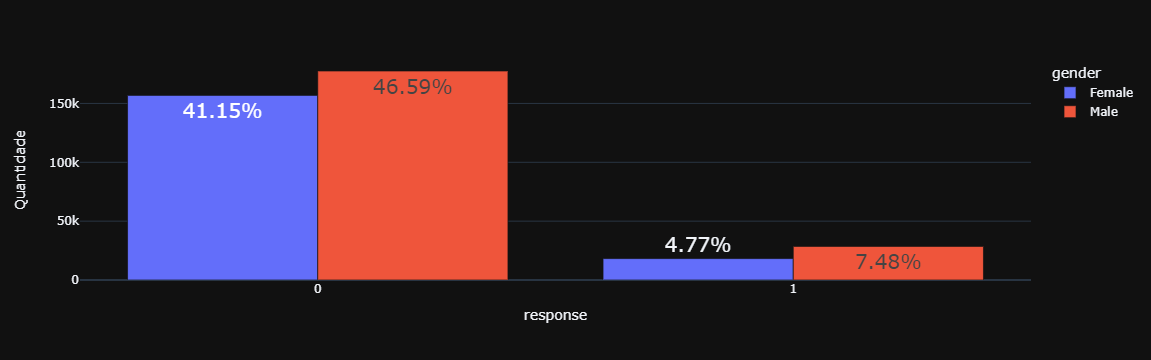

In [17]:
# Interessados no seguro de acordo com o gênero
df_aux1 = df1.loc[:, ['id','gender', 'response']].groupby(['gender','response']).count().reset_index()
df_aux1['percentage'] = df_aux1['id'] / df_aux1['id'].sum() * 100

# Criar o gráfico
fig1 = px.bar(df_aux1,
       x='response',
       y='id',
       labels = {'id': 'Quantidade'},
       color='gender',
       text=df_aux1['percentage'].apply(lambda x: '{0:1.2f}%'.format(x)),
       barmode='group',
       color_discrete_sequence=px.colors.qualitative.Plotly)


fig1.update_traces(texttemplate='%{text}', textfont=dict(size=20))
fig1.update_layout(template='plotly_dark')

fig1.show()

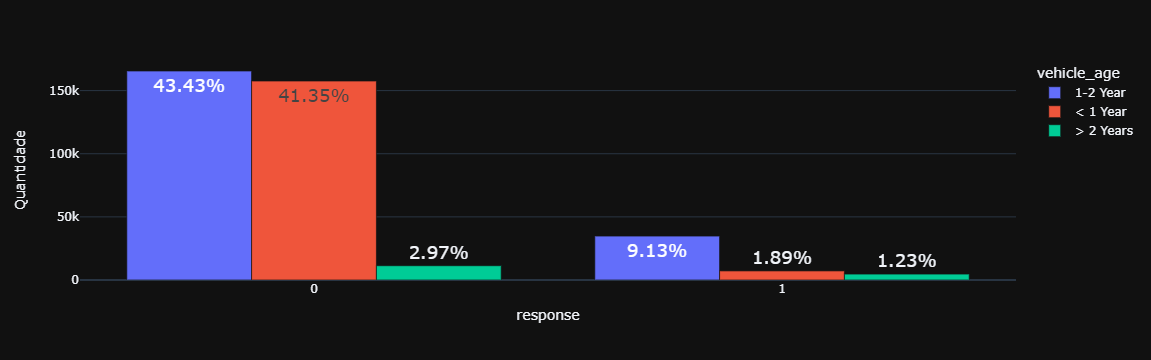

In [18]:
# # Interessados no seguro de acordo com a idade do carro
df_aux2 = df1.loc[:, ['id','vehicle_age', 'response']].groupby(['vehicle_age','response']).count().reset_index()
df_aux2['percentage'] = df_aux2['id'] / df_aux2['id'].sum() * 100

# Criar o gráfico
fig2 = px.bar(df_aux2,
       x='response',
       y='id',
       labels = {'id': 'Quantidade'},
       color='vehicle_age',
       text=df_aux2['percentage'].apply(lambda x: '{0:1.2f}%'.format(x)),
       barmode='group',
       color_discrete_sequence=px.colors.qualitative.Plotly)


fig2.update_traces(texttemplate='%{text}',textfont=dict(size=18))
fig2.update_layout(template='plotly_dark')

fig2.show()

# 2.0. Feature Engineering

In [19]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

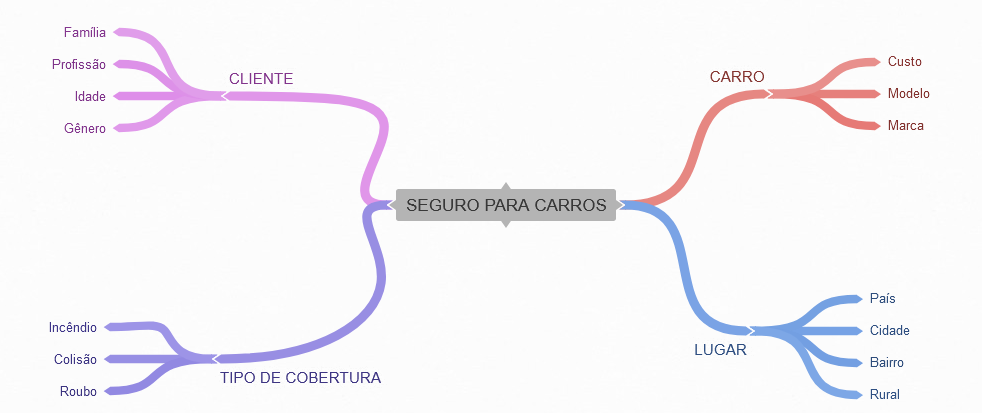

In [20]:
Image ('img/mind_map.PNG')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Clientes

**1.** Clientes com família possuem maior probabilidade de adquirir um seguro para carro.

**2.** Clientes do gênero feminino possuem maior probabilidade de adquirir um seguro para carro.

**3.** Clientes mais velhos possuem maior probabilidade de adquirir um seguro para carro.

**4.** Clientes que ganham bem possuem maior probabilidade de adquirir um seguro para carro.

**5.** Clientes que não possuem carteira de motorista são menos propensos a adquirir um seguro de automóvel.

### 2.2.2 Hipóteses Lugar

**1.** Clientes que vivem em cidades possuem maior probabilidade de adquirir um seguro para carro.

**2.** Clientes que vivem em áreas rurais possuem menor probabilidade de adquirir um seguro para carro.

**3.** Clientes que vivem em lugares perigosos possuem maior probabilidade de adquirir um seguro para carro.

**4.** Clientes que vivem em regiões com maior índice de acidentes possuem maior probabilidade de adquirir um seguro para carro.

### 2.2.3 Hipóteses Carro

**1.** Clientes que possuem carros mais caros são mais propensos a adquirir um seguro para carro.

**2.** Clientes que possuem carros novos são mais propensos a adquirir um seguro para carro.

**3.** Clientes que possuem carros usados são menos propensos a adquirir um seguro para carro.

**4.** Clientes que possuem carros com marcas populares são mais propensos a adquirir um seguro para carro.

### 2.2.4 Hipóteses Tipo de Cobertura

**1.** Clientes que já sofreram acidentes automobilísticos são mais propensos a adquirir um seguro para carro.

**2.** Seguros de automóvel em promoções deveriam vender mais.

**3.** Seguros de automóvel com um bom marketing deveriam vender mais.

**4.** Seguro de automóvel com menos concorrentes deveriam vender mais.

**5.** Clientes que possuem seguro de vida devem são mais propensos a adquirir um seguro de automóvel.

**6.** Clientes que tiveram um seguro de carro anterior são mais propensos a adquirir um seguro de carro

## 2.3 Lista Final de Hipóteses

**1.** Clientes mais velhos possuem maior probabilidade de adquirir um seguro para carro.

**2.** Clientes do gênero feminino possuem maior probabilidade de adquirir um seguro para carro.

**3.** Clientes que não possuem carteira de motorista são menos propensos a adquirir um seguro de carro.

**4.** Clientes com prêmio anuais altos são mais propensos a adquirir um seguroi  querer mais seguro de carro.

**5.** Clientes que vivem em cidades possuem maior probabilidade de adquirir um seguro para carro.

**6.** Clientes que já sofreram acidentes automobilísticos são mais propensos a adquirir um seguro para carro.

**7.** Clientes que possuem carros novos são mais propensos a adquirir um seguro para carro.

**8.** Clientes que tiveram um seguro de carro anterior são mais propensos a adquirir um seguro de carro.

**9.** Clientes que possuem seguro de vida devem são mais propensos a adquirir um seguro de carro.

**10.** Clientes que vivem em regiões com maior índice de acidentes possuem maior probabilidade de adquirir um seguro para carro.

## 2.4 Feature Engineering

In [21]:
# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'usado' if x == '> 2 Years' else 'seminovo' if x == '1-2 Year' else 'novo' )

In [22]:
df2.head().T

0         1      2      3       4
id                        1         2      3      4       5
gender                 Male      Male   Male   Male  Female
age                      44        76     47     21      29
driving_license           1         1      1      1       1
region_code              28         3     28     11      41
previously_insured        0         0      0      1       1
vehicle_age           usado  seminovo  usado   novo    novo
vehicle_damage            1         0      1      0       0
annual_premium        40454     33536  38294  28619   27496
policy_sales_channel     26        26     26    152     152
vintage                 217       183     27    203      39
response                  1         0      1      0       0

# 3.0 Data Filtering

In [23]:
df3 = df2.copy()

# 4.0  Exploratory Data Analysis

In [24]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

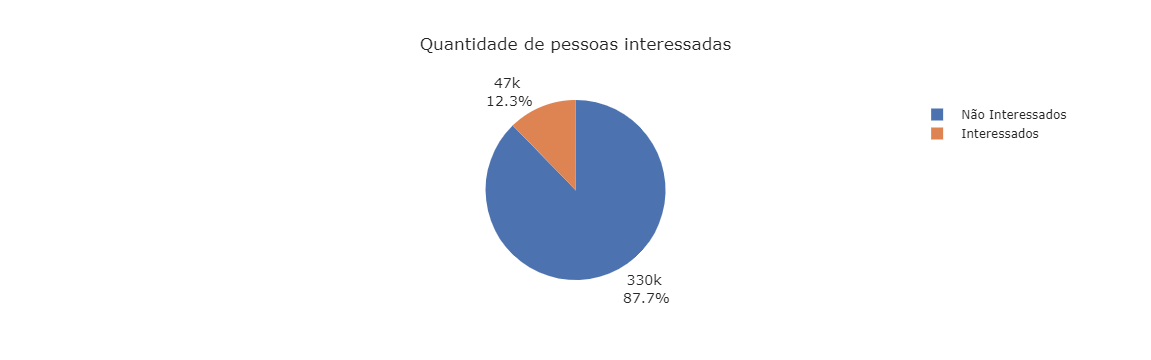

In [25]:
df_aux = df4.loc[:, ['id', 'response']].groupby('response').count().reset_index()

fig = px.pie(df_aux,
       values='id',
       names=[" Não Interessados", " Interessados"],
       title='Quantidade de pessoas interessadas',
       labels = {'id': 'Quantidade'}
      )

fig.update_traces(texttemplate='%{value:.2s}<br> %{percent}',textposition='outside', textfont_size=14)

fig.update_layout(template='seaborn')
fig.show()

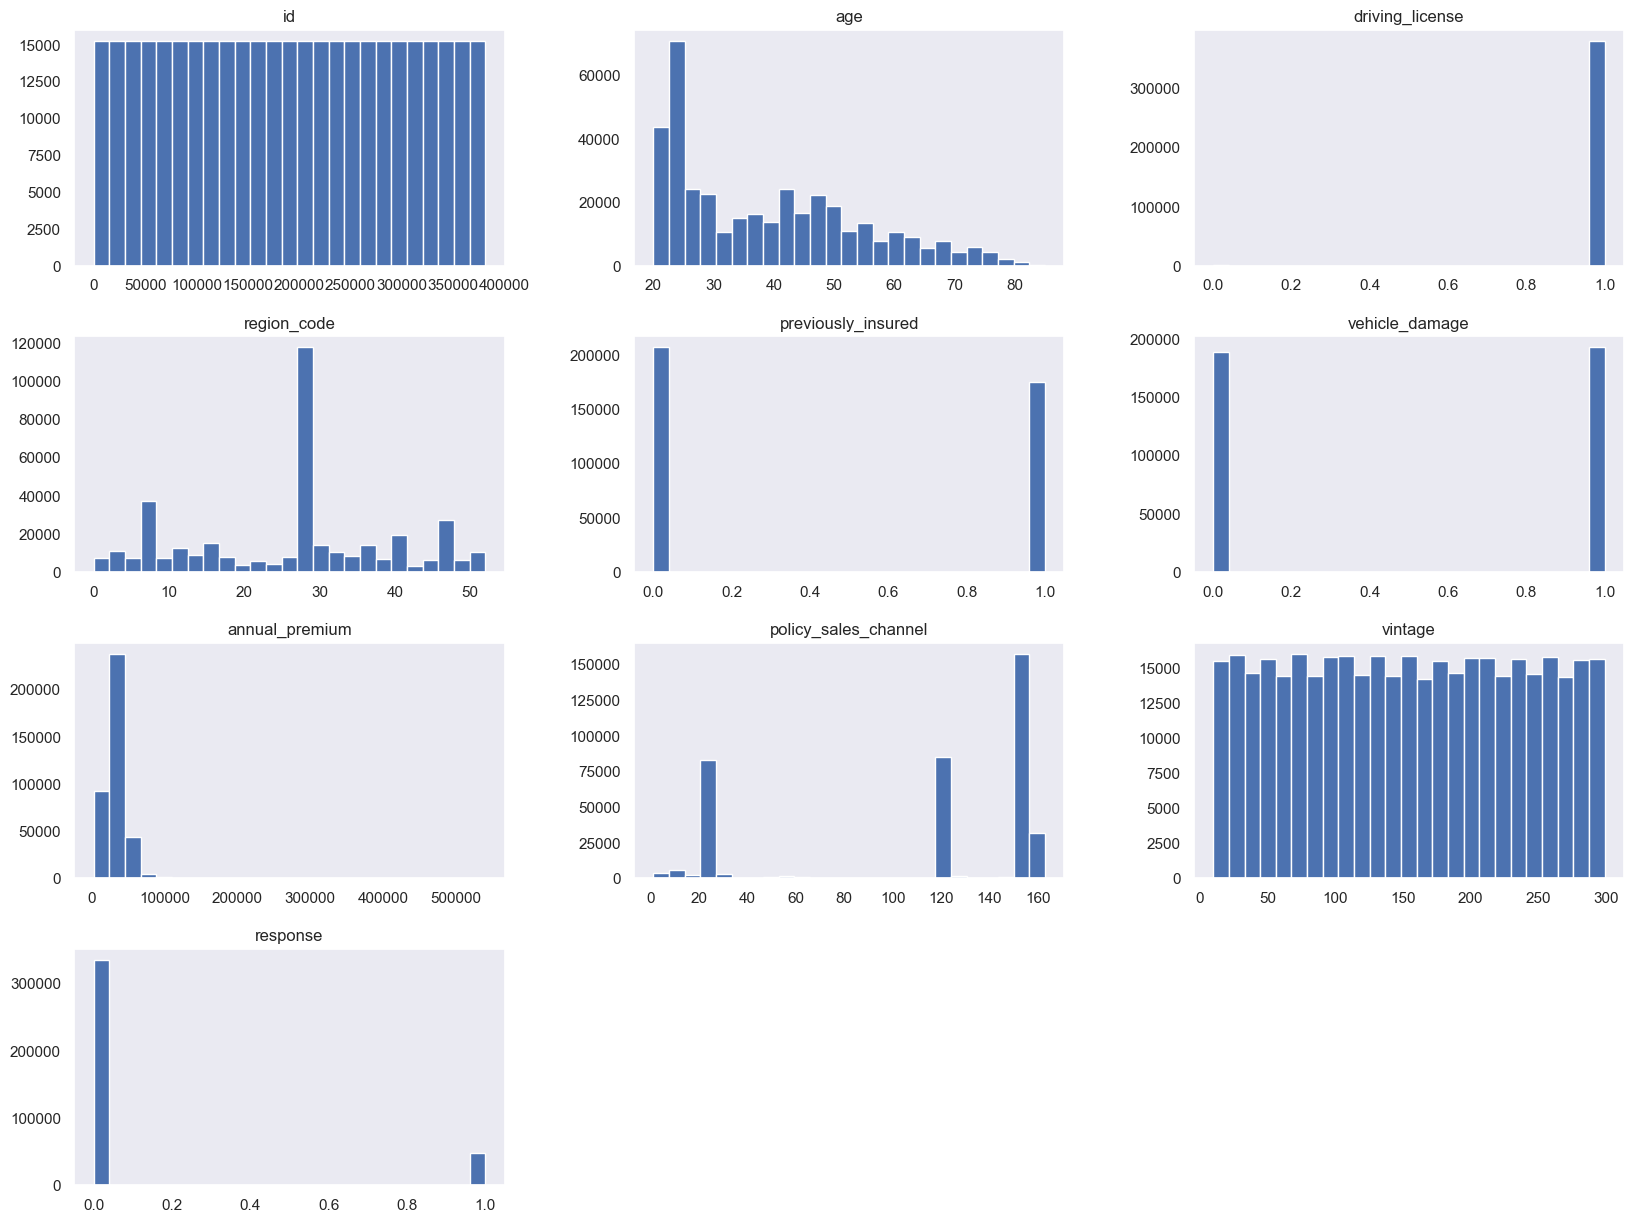

In [26]:
fig = plt.figure(figsize = (20,15))
num_attributes.hist(bins = 25, ax = fig.gca(), grid = False);

### 4.1.3 Categorical Variable

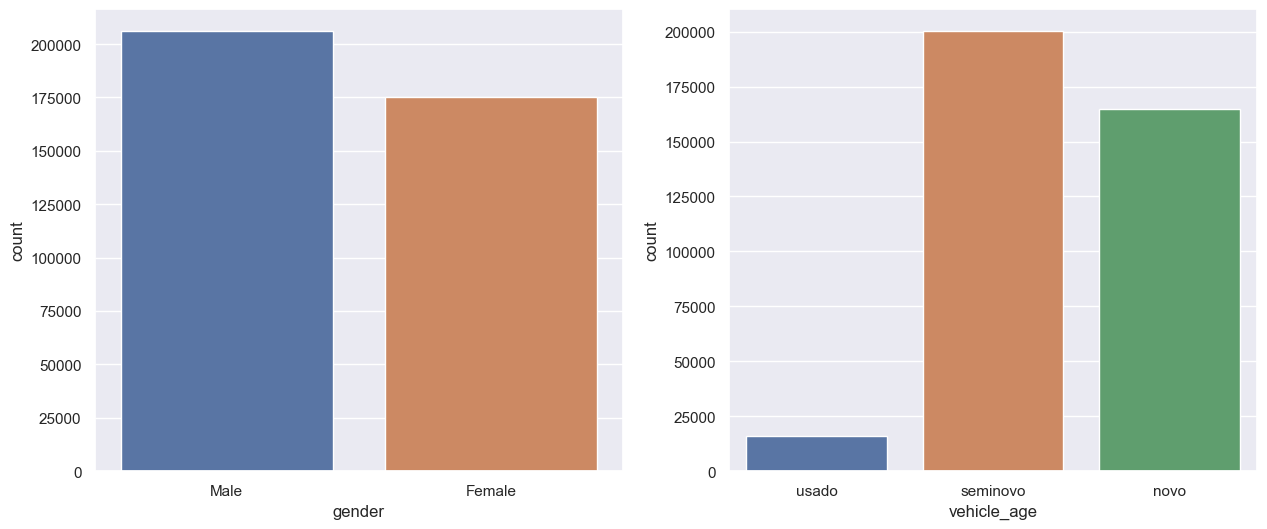

In [27]:
# Criar a figura
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# gender
sns.countplot(
    x="gender",
    data=df4,
    ax=axs[0],
)

# vehicle_age
sns.countplot(
    x="vehicle_age",
    data=df4,
    ax=axs[1],
)

plt.show()

## 4.2 Análise Bivariada

### **H1.** Clientes mais velhos possuem maior probabilidade de adquirir um seguro para carro.

**Falsa**  - Clientes entre 30 e 50 anos possuem maior probabilidade de adquirir um seguro para carro.

<AxesSubplot: >

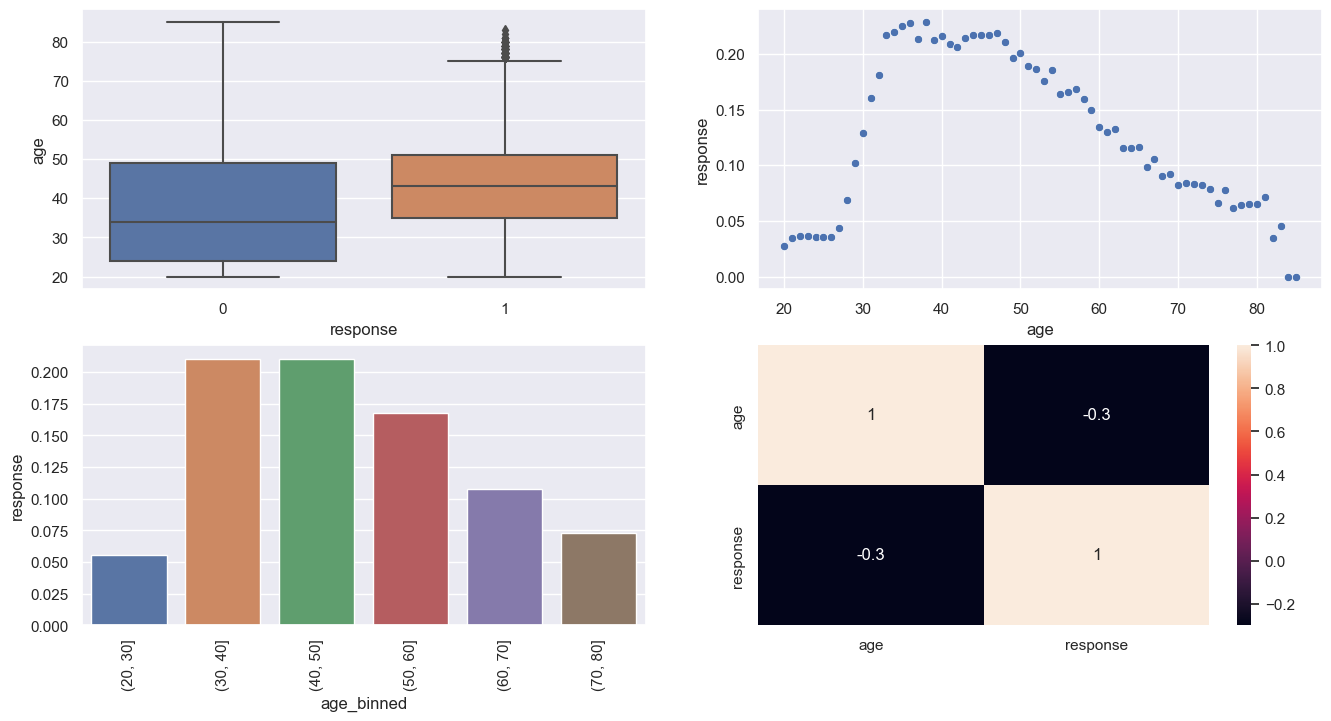

In [28]:
fig = plt.figure(figsize = (16,8))

plt.subplot (2,2,1)
sns.boxplot( x='response', y='age', data=df4 )

plt.subplot (2,2,2)
df_aux3 = df4[['age', 'response']].groupby ('age').mean().reset_index()
sns.scatterplot(x = 'age', y = 'response', data = df_aux3)

plt.subplot (2,2,3)
bins = list(np.arange(20, 90, 10))
df_aux3['age_binned'] = pd.cut (df_aux3['age'], bins = bins)
df_aux4 = df_aux3[['age_binned', 'response']].groupby ('age_binned').mean().reset_index()
sns.barplot(x = 'age_binned', y = 'response', data = df_aux4)
plt.xticks(rotation = 90);

plt.subplot (2,2,4)
sns.heatmap(df_aux3.corr(method= 'pearson'), annot = True)

### **H2.** Clientes do gênero feminino possuem maior probabilidade de adquirir um seguro para carro.

**Falsa**  - Clientes do gênero masculino possuem maior probabilidade de adquirir um seguro para carro

<AxesSubplot: xlabel='gender', ylabel='response'>

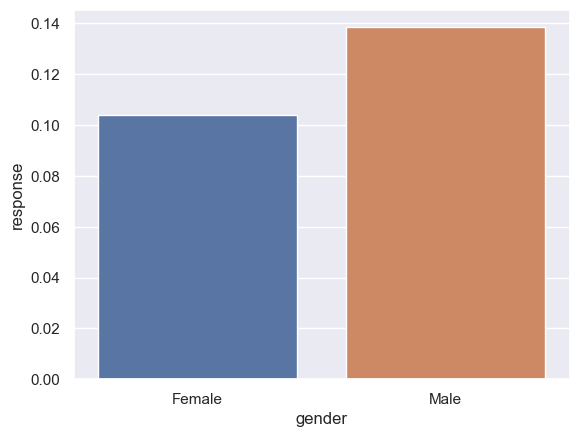

In [29]:
df_aux1 = df4[['gender', 'response']].groupby(['gender']).mean().reset_index()
sns.barplot (x = 'gender', y = 'response', data = df_aux1)

### **H3.** Clientes que não possuem carteira de motorista são menos propensos a adquirir um seguro de carro.

**Verdadeira**  - Clientes que não possuem carteira são menos propensos a adquirir um seguro de carro.

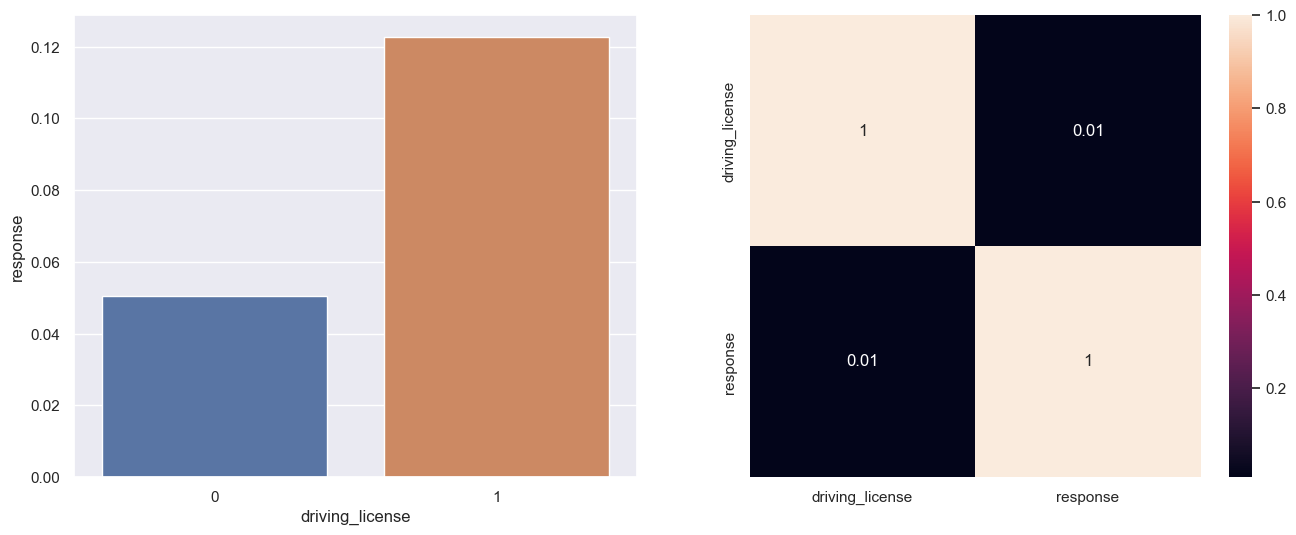

In [30]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,2,1)
df_aux1 = df4[['driving_license', 'response']].groupby('driving_license').mean().reset_index()
sns.barplot (x = 'driving_license', y = 'response', data = df_aux1);

plt.subplot (1,2,2)
df_aux2 = df4[['driving_license', 'response']]
sns.heatmap(df_aux2.corr(method= 'pearson'), annot = True);

### **H4.** Clientes com os maiores prêmios anuais são mais propensos a adquirir um seguro de carro

**Verdadeira** - Clientes com os maiores prêmios anuais são mais propensos a adquirir um seguro de carro

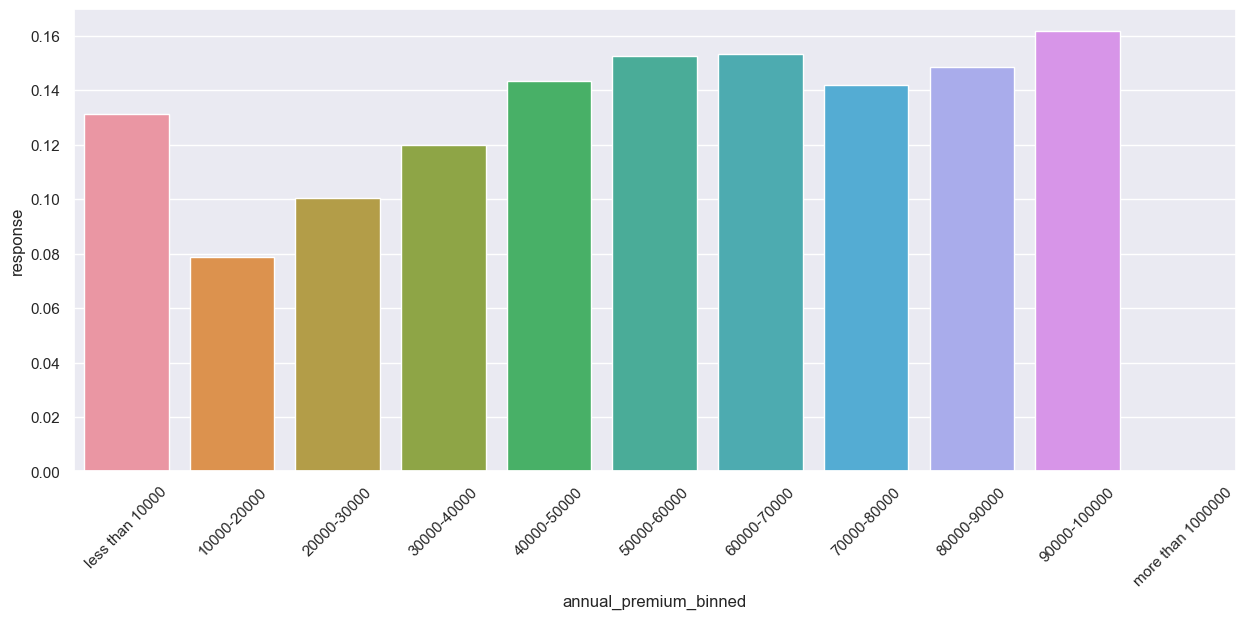

In [31]:
df_aux = df4.loc[:, ['id','annual_premium', 'response']]
df_aux['annual_premium_binned'] = df4['annual_premium'].apply( lambda x: 'less than 10000' if x < 10000
                                                            else '10000-20000' if 10000 <= x < 20000 
                                                            else '20000-30000' if 20000 <= x < 30000 
                                                            else '30000-40000' if 30000 <= x < 40000 
                                                            else '40000-50000' if 40000 <= x < 50000 
                                                            else '50000-60000' if 50000 <= x < 60000 
                                                            else '60000-70000' if 60000 <= x < 70000 
                                                            else '70000-80000' if 70000 <= x < 80000  
                                                            else '80000-90000' if 80000 <= x < 90000 
                                                            else '90000-100000' if 90000 <= x < 100000 
                                                            else 'more than 100000')

df_aux2 = df_aux[['annual_premium_binned', 'response']].groupby ('annual_premium_binned').mean().reset_index()


fig = plt.figure(figsize = (15,6))


sns.barplot(
    x="annual_premium_binned",
    y ="response",
    data= df_aux2,
    
    order = ['less than 10000','10000-20000','20000-30000','30000-40000', 
                     '40000-50000','50000-60000','60000-70000','70000-80000', 
                     '80000-90000','90000-100000','more than 1000000'])
plt.xticks(rotation = 45);


### **H5.** Clientes que vivem em cidades possuem maior probabilidade de adquirir um seguro para carro.

**Verdadeira** - Clientes que em cidades possuem maior probabilidade de adquirir um seguro para carro.

<AxesSubplot: xlabel='region_code', ylabel='count'>

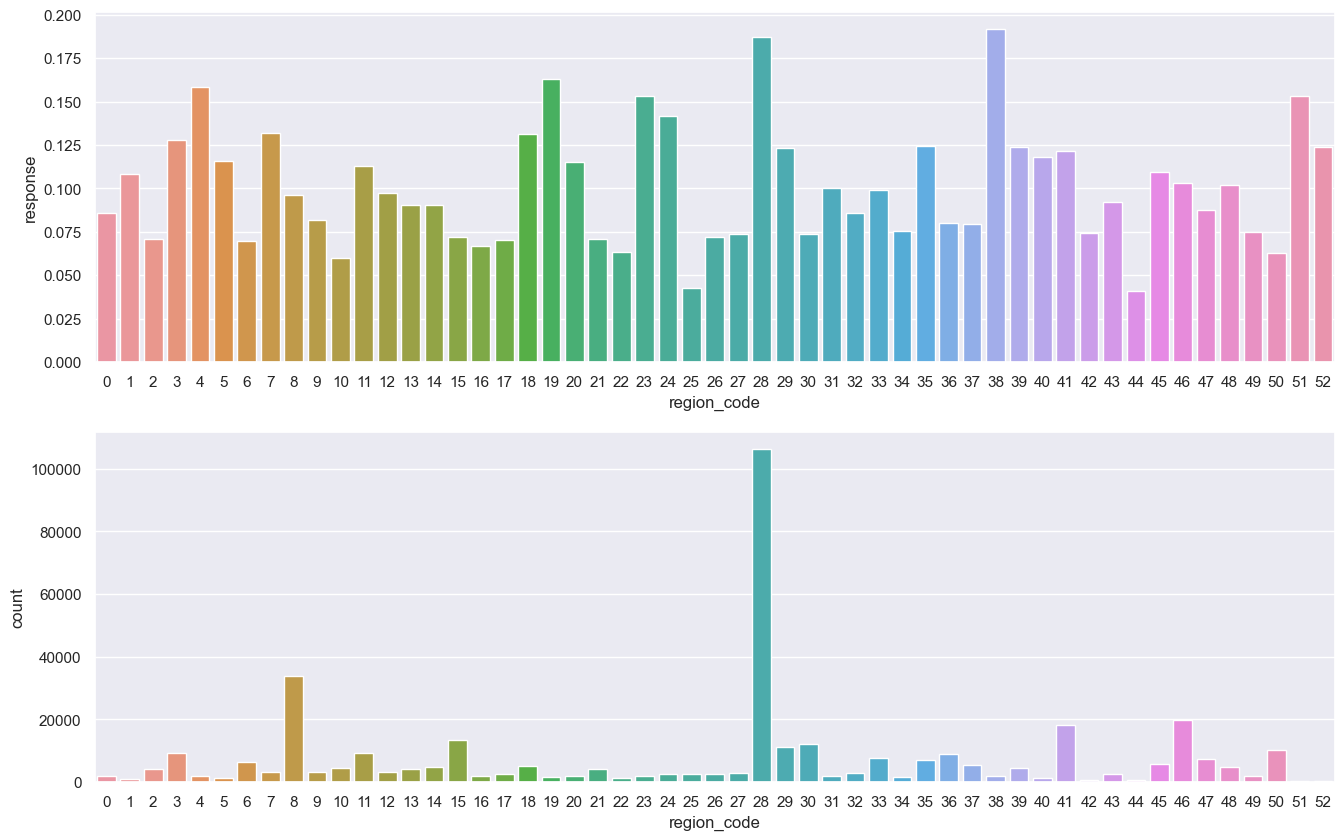

In [32]:
fig = plt.figure(figsize = (16,10))

df_aux = df4[['region_code', 'response']].groupby('region_code').mean().reset_index()

plt.subplot (2,1,1)
sns.barplot (x = 'region_code',
             y = 'response',
             data = df_aux);

plt.subplot (2,1,2)
sns.countplot( x="region_code", 
               data=df4)

### **H6.** Clientes que já sofreram acidentes automobilísticos são mais propensos a adquirir um seguro para carro.

**Verdadeira** - Clientes que já sofreram acidentes automobilísticos são mais propensos a adquirir um seguro para carro.

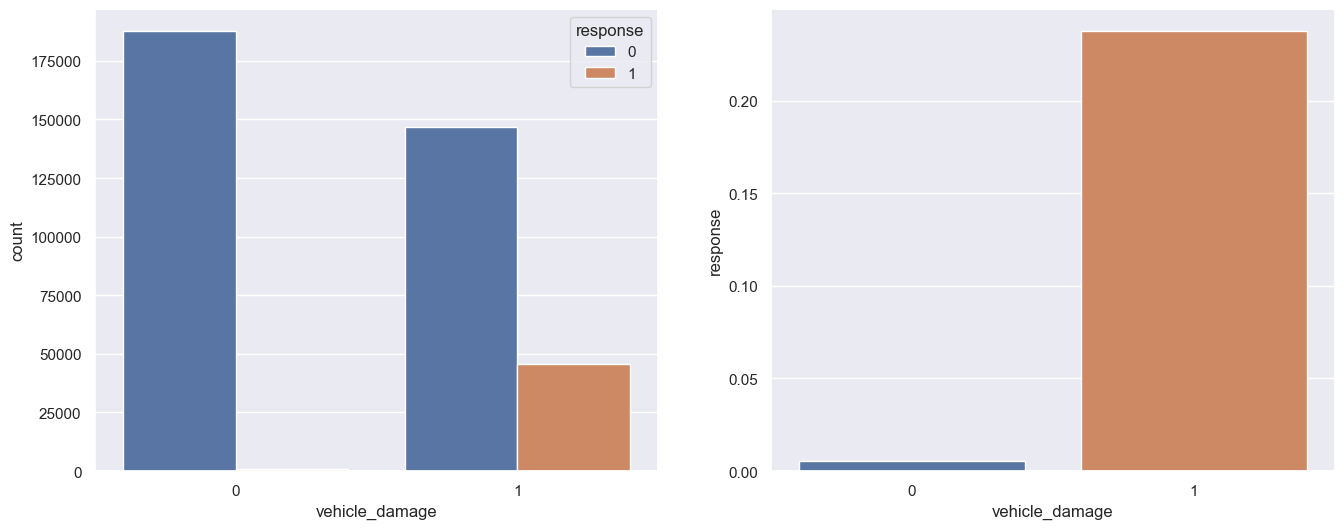

In [33]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,2,1)
sns.countplot (x = 'vehicle_damage',
              hue = 'response',
              data = df4)

plt.subplot (1,2,2)
df_aux = df4[['vehicle_damage', 'response']].groupby('vehicle_damage').mean().reset_index()
sns.barplot (x = 'vehicle_damage',
             y = 'response',
             data = df_aux);

### **H7.** Clientes que possuem carros novos são mais propensos a adquirir um seguro para carro.

**Falso** - Clientes que possuem carros usados são mais propensos a adquirir um seguro para carro.

<AxesSubplot: xlabel='vehicle_age', ylabel='response'>

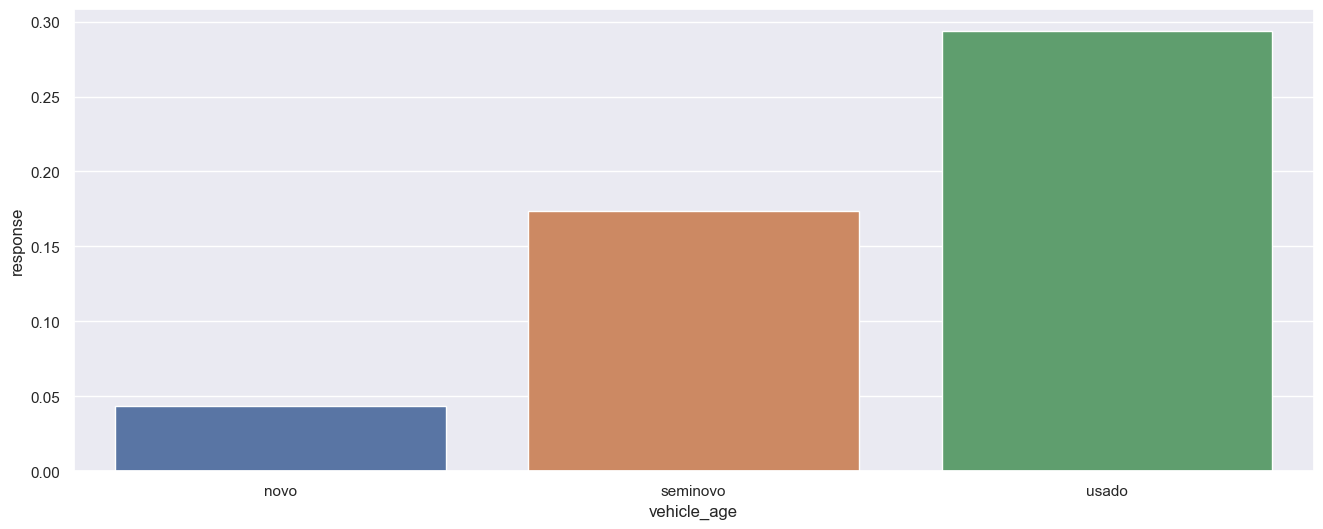

In [34]:
fig = plt.figure(figsize = (16,6))

df_aux = df4[['vehicle_age', 'response']].groupby('vehicle_age').mean().reset_index()
sns.barplot (x = 'vehicle_age', y = 'response', data = df_aux)

### **H8.** Clientes que tiveram um seguro de carro anterior são mais propensos a adquirir um seguro de carro.
**Falso** - Clientes que tiveram um seguro de carro anterior não são mais propensos a adquirir um seguro de carro.

<AxesSubplot: xlabel='previously_insured', ylabel='response'>

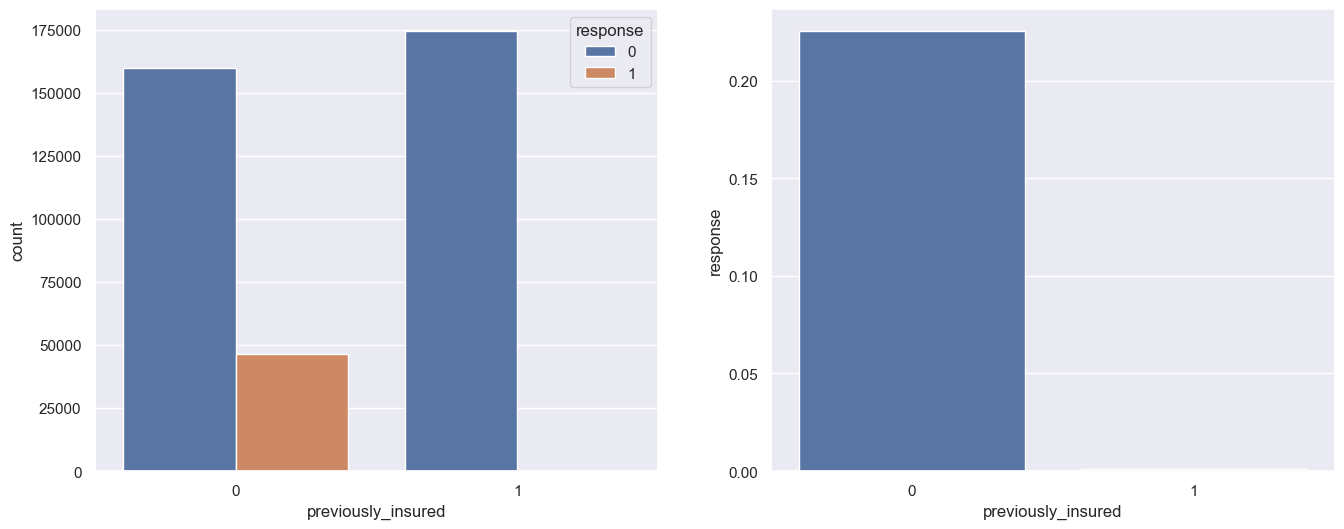

In [35]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,2,1)
sns.countplot(x = 'previously_insured',
              hue = 'response',
              data = df4);

plt.subplot (1,2,2)
df_aux = df4[['previously_insured', 'response']].groupby('previously_insured').mean().reset_index()
sns.barplot (x = 'previously_insured', y = 'response', data = df_aux)

### **H9.** Clientes que possuem seguro de vida são mais propensos a adquirir um seguro de carro.
**Falso** - Clientes que possuem seguro de vida não são mais propensos a adquirir um seguro de carro.

<AxesSubplot: xlabel='response', ylabel='vintage'>

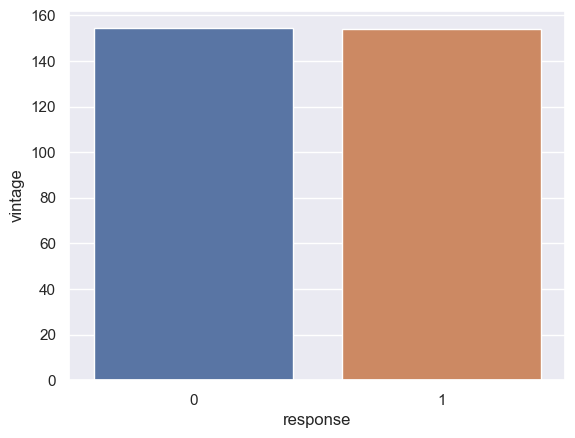

In [36]:
df_aux = df4.loc[:,['response','vintage']].groupby('response').mean().reset_index()
sns.barplot (x = 'response', y = 'vintage', data = df_aux)

<Figure size 1600x600 with 0 Axes>

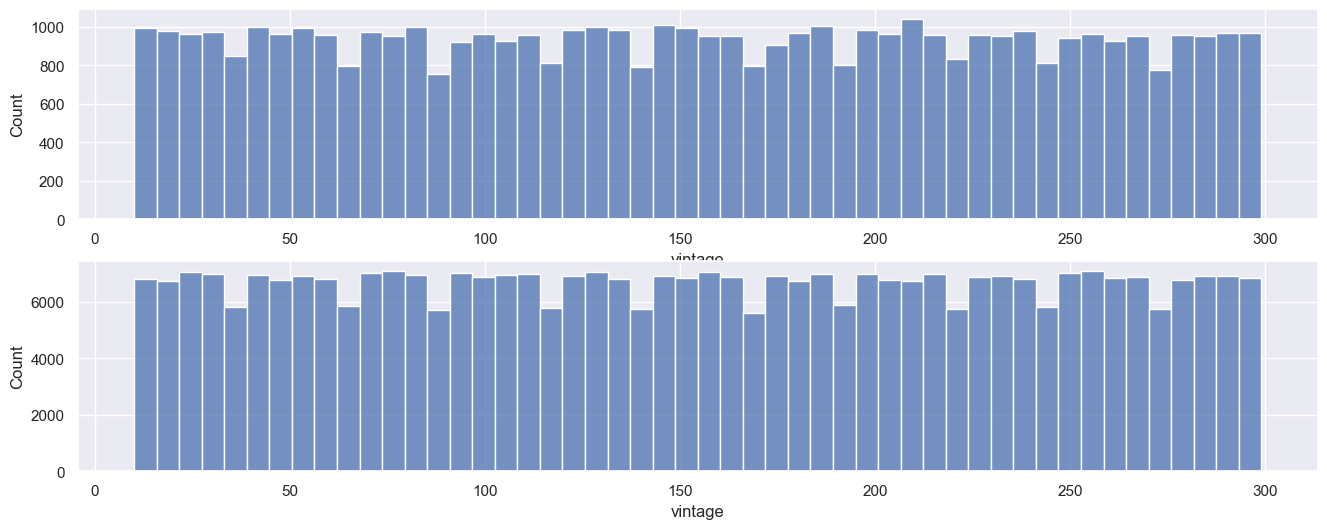

In [37]:
fig = plt.figure(figsize = (16,6))

grid = GridSpec( 2, 2 )
fig = plt.figure(figsize = (16,6))

plt.subplot (grid[0,:])
sns.histplot(x = 'vintage', bins = 50, data = df4[df4['response'] == 1]);


plt.subplot (grid[1,:])
sns.histplot(x = 'vintage', bins = 50, data = df4[df4['response'] == 0]);

### **H10.** Clientes que vivem em regiões com maior índice de acidentes possuem maior probabilidade de adquirir um seguro para carro.
**Verdadeira** - Clientes que vivem em regiões com maior índice de acidentes possuem maior probabilidade de adquirir um seguro para carro.

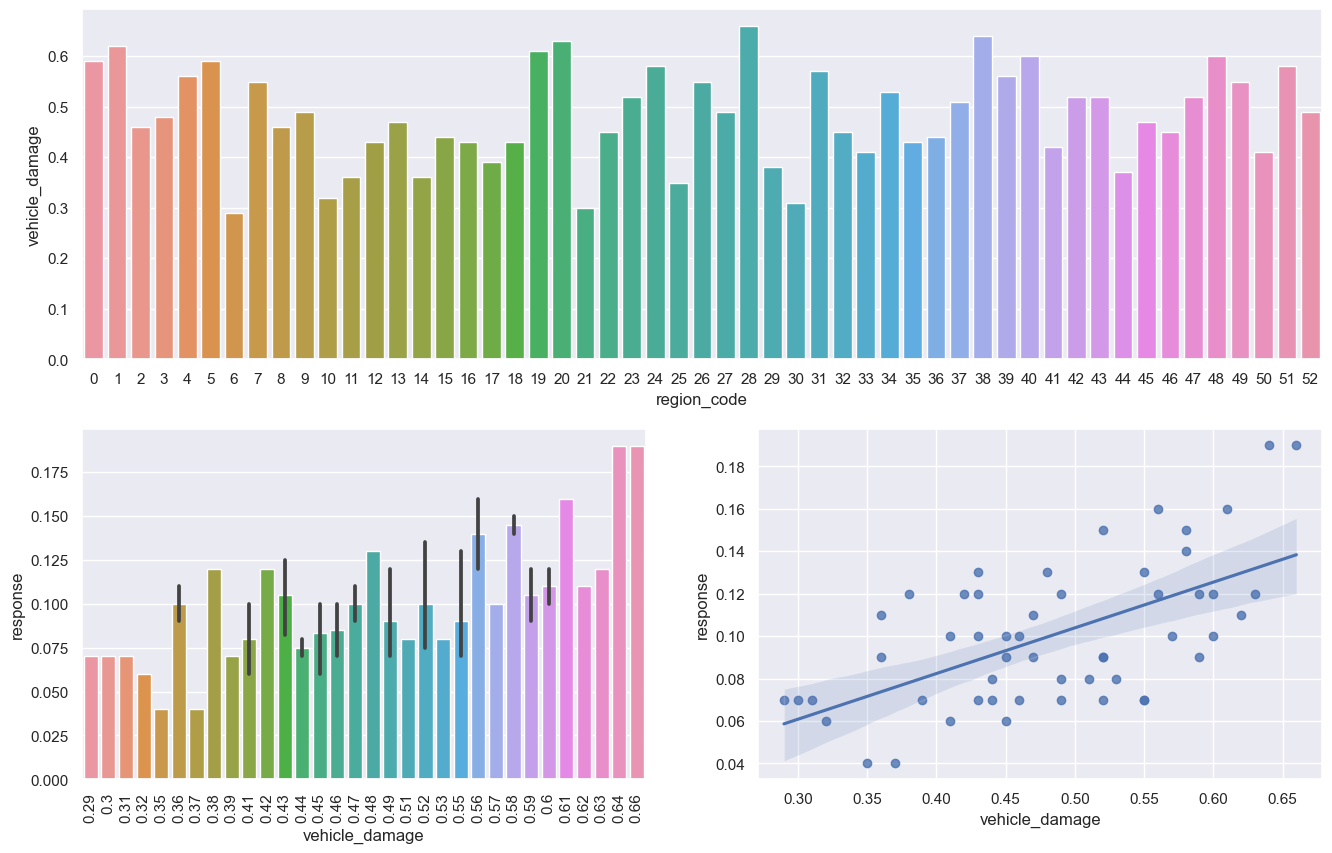

In [38]:
df_aux = round(df4.loc[:, ['vehicle_damage','region_code','response']]
             .groupby(['region_code'])
             .mean()
             .sort_values('vehicle_damage', ascending = True)
             .reset_index(), 2)

grid = GridSpec( 2, 2 )
fig = plt.figure(figsize = (16,10))

plt.subplot (grid[0,:])
sns.barplot(x = 'region_code', y = 'vehicle_damage', data = df_aux);

plt.subplot (grid[1,0])
sns.barplot(x = 'vehicle_damage', y = 'response', data = df_aux);
plt.xticks(rotation = 90);

plt.subplot (grid[1,1])
sns.regplot(x = 'vehicle_damage', y = 'response', data = df_aux);

### 4.2.1 Resumo das Hipóteses

In [39]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Alta'],
['H2', 'Falsa', 'Baixa'],
['H3', 'Verdadeira', 'Alta'],
['H4', 'Verdadeira', 'Alta'],
['H5', 'Verdadeira', 'Media'],
['H6', 'Verdadeira', 'Alta'],    
['H7', 'Falsa', 'Alta'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Baixa'],
['H10','Verdadeira', 'Media']
]
print( tabulate( tab, headers='firstrow' ) )



Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Alta
H2           Falsa        Baixa
H3           Verdadeira   Alta
H4           Verdadeira   Alta
H5           Verdadeira   Media
H6           Verdadeira   Alta
H7           Falsa        Alta
H8           Falsa        Media
H9           Falsa        Baixa
H10          Verdadeira   Media


## 4.3 Análise Multivariada

In [40]:
# Divide features in numerical, categorical and binary
num_attributes = df4[['age','region_code', 'annual_premium', 'vintage']]
bin_attributes = df4[['driving_license', 'vehicle_damage', 'previously_insured', 'response']]
cat_attributes = df4.select_dtypes(exclude = ['int64'])

### 4.3.1. Numerical Attributes

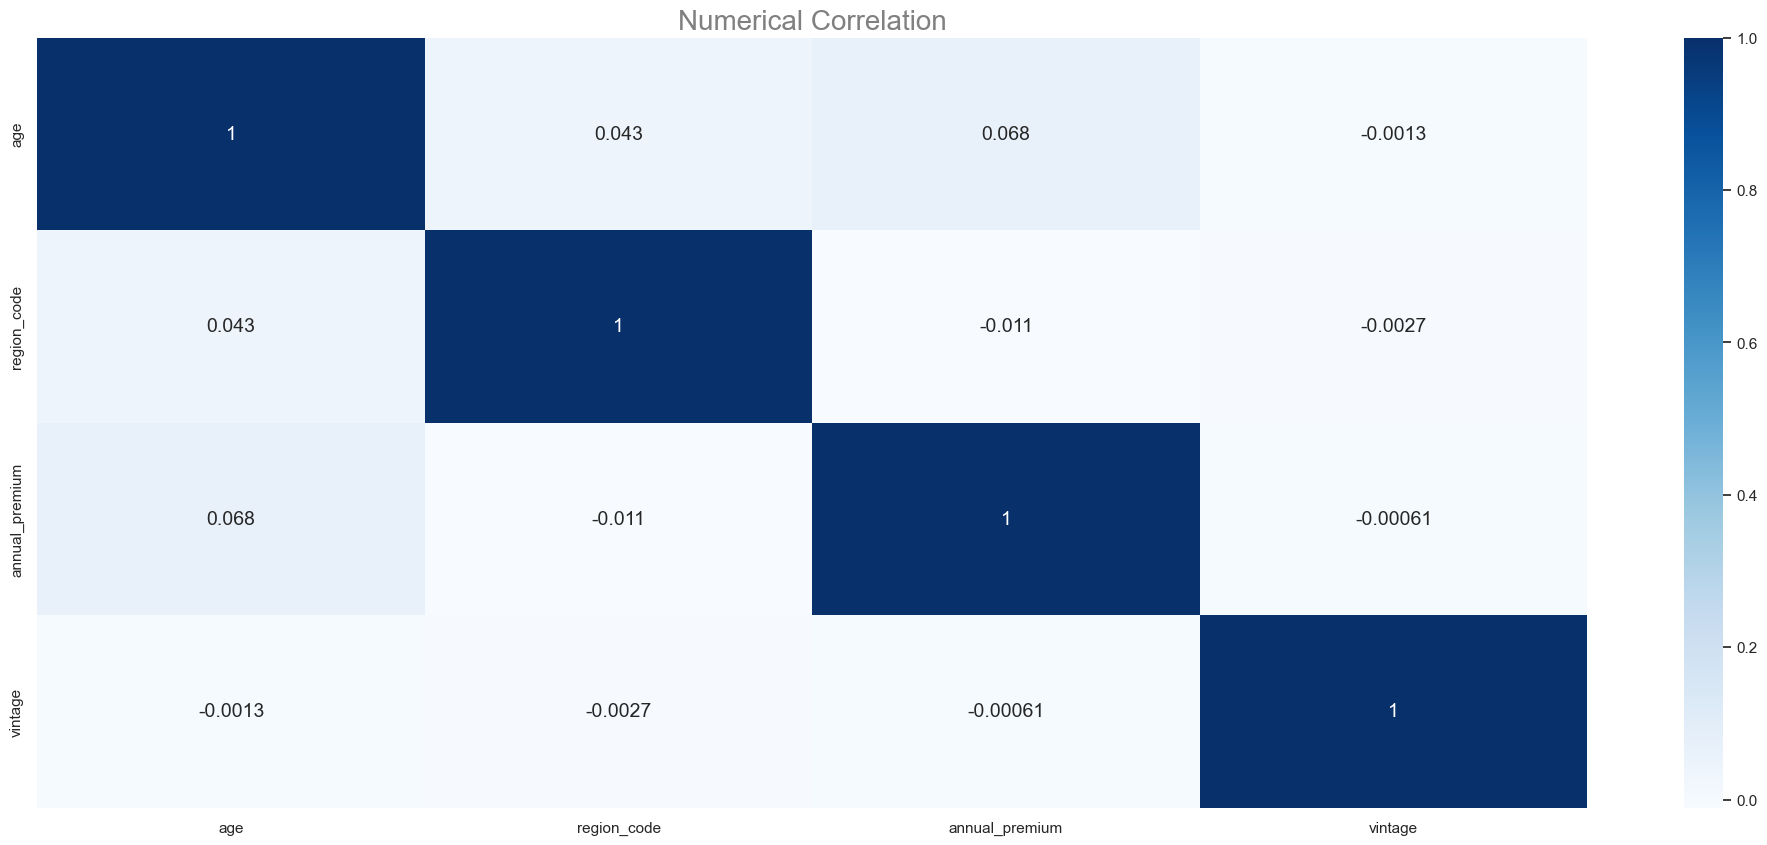

In [41]:
fig = plt.figure(figsize = (25,10))
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Numerical Correlation", size=20, color='gray');

### 4.3.2. Binary Attributes x Numerical Attributes

Text(0.5, 1.0, 'Point Biserial Correlation')

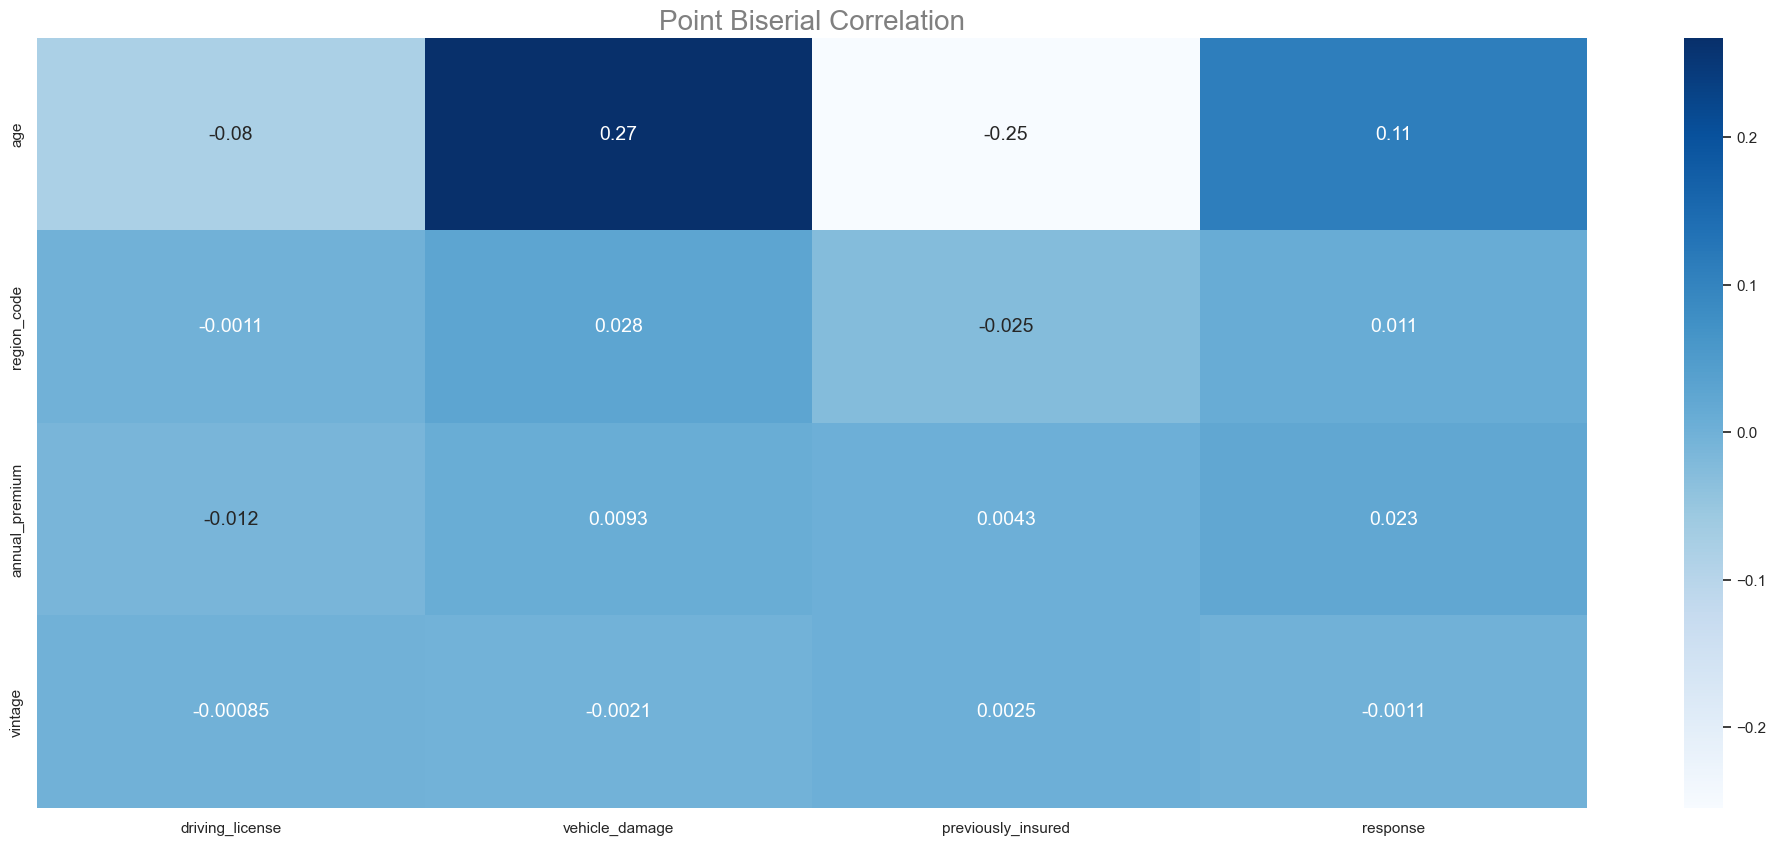

In [42]:
# Crio um dicionário para guardar os valores de correlação
correlation_values = {}

# Passar por cada atributo binário
for bin_attr in bin_attributes.columns:
    correlation_values[bin_attr] = []
    # Passar por cada atributo numérico
    for num_attr in num_attributes.columns:
        # Calcular o ponto bisserial de correlação e adicionar na lista
        correlation_values[bin_attr].append(pointbiserialr(bin_attributes[bin_attr], num_attributes[num_attr])[0])
        
# Final DataFrame
d = pd.DataFrame(correlation_values, index=num_attributes.columns)

fig = plt.figure(figsize = (25,10))
sns.heatmap(d, annot = True, annot_kws={"fontsize":14}, cmap="Blues")
plt.title("Point Biserial Correlation", size=20, color='gray')

### 4.3.3 Categorical Attributes

Text(0.5, 1.0, 'Categorical Correlation')

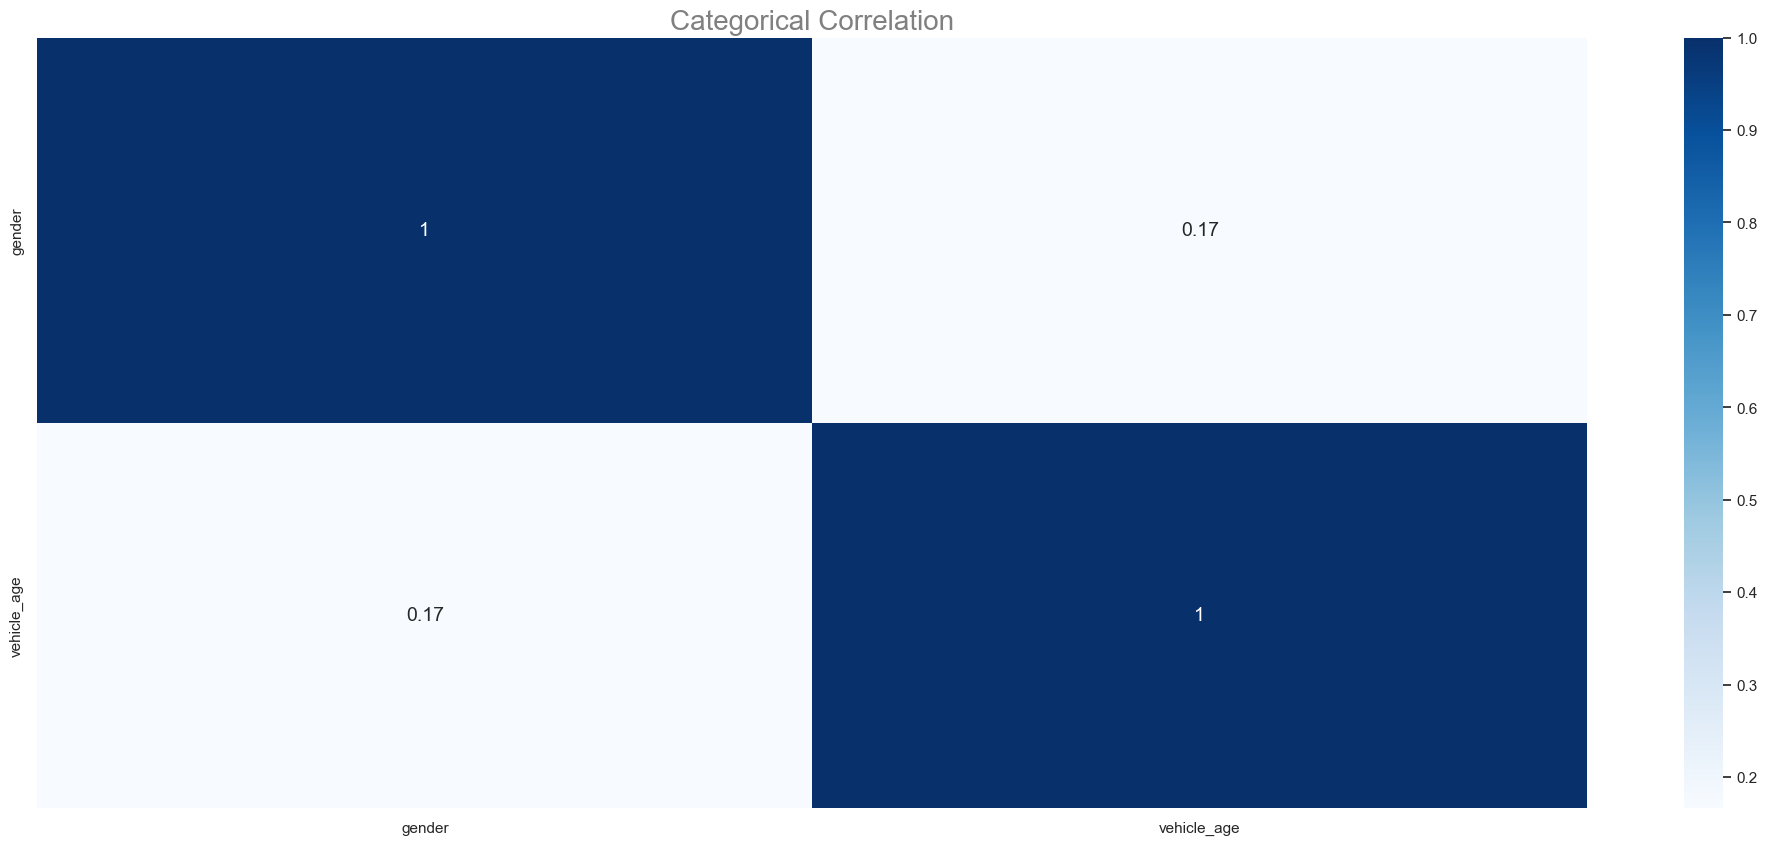

In [43]:
# Inicializa um dicionário vazio para armazenar os valores de Cramér V
correlation_values = {}

# Loop sobre cada atributo categórico
for cat_attr in cat_attributes.columns:
    correlation_values[cat_attr] = []
    # Loop sobre cada atributo categórico
    for cat_attr2 in cat_attributes.columns:
        # Calcula o coeficiente de Cramér V e adiciona à lista
        correlation_values[cat_attr].append(cramer_v(cat_attributes[cat_attr], cat_attributes[cat_attr2]))

# Cria o DataFrame final
d = pd.DataFrame(correlation_values, index=cat_attributes.columns)

fig = plt.figure(figsize = (25,10))
sns.heatmap(d, annot = True, annot_kws={"fontsize":14}, cmap="Blues")
plt.title("Categorical Correlation", size=20, color='gray')

# 5.0 Data Preparation

In [44]:
df5 = df4.copy()

In [45]:
X = df4.drop( 'response', axis = 1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20, stratify=y)

df5= pd.concat( [ x_train, y_train], axis= 1)

## 5.1 Rescaling Features

In [46]:
# duas instâncias separadas

mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()
rs = RobustScaler()

# Age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values)

# Vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values)

# Annual Premium - RobustScaler

df5['annual_premium'] = rs.fit_transform(df5[['annual_premium']].values)

## 5.2 Features Transformation

### 5.2.1 Encoding

In [47]:
# One Hot Encoding / Frequency Encoding / Target Encoding

# Gender- Target encoding
target_encode_gender = df5.groupby( 'gender')['response'].mean()
df5.loc[ :, 'gender'] = df5['gender'].map( target_encode_gender )

# Region Code- Target encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean() 
df5.loc[ :, 'region_code'] = df5['region_code'].map ( target_encode_region_code)

# Vehicle Age- One hot encoding
df5 = pd.get_dummies( df5, prefix= 'vehicle_age', columns= ['vehicle_age' ] )

# Policy Sales Channel - Frequency encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel').size()/len( df5 )
df5.loc[:, 'policy_sales_channel']= df5['policy_sales_channel'].map ( fe_policy_sales_channel )

## 5.3 Validation Preparation

In [48]:
# gender
x_validation.loc[ :, 'gender'] = x_validation.loc[ :, 'gender'].map ( target_encode_gender)

# age
x_validation.loc[ :, 'age'] = mms_age.transform( x_validation[['age']].values)

# region_code
x_validation.loc[ :, 'region_code'] = x_validation.loc[ :, 'region_code'].map( target_encode_region_code)

# vehicle age
x_validation = pd.get_dummies( x_validation, prefix= 'vehicle_age', columns= ['vehicle_age'])

# annual premium
x_validation.loc[:, 'annual_premium'] = rs.transform( x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values)

#fillna
x_validation = x_validation.fillna(0)

# 6.0 Feature Selection

In [49]:
df6 = df5.copy()

## 6.1. Boruta Algorithm

In [52]:
#x_train_n = df6.drop( ['id', 'response'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# Define model
#et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define boruta
#boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
I

In [133]:
#cols_selected = boruta.support_.tolist()

# best features
#x_train_fs = df5.drop( ['id', 'response'], axis=1 )
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 6.2. Feature Importance

In [50]:
# model definition
forest= en.ExtraTreesClassifier( n_estimators= 250, random_state=0, n_jobs=-1)

# Data preparation
x_train_n= df6.drop(['id','response'], axis=1)
y_train_n= y_train.values
forest.fit( x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking
                feature  importance
0               vintage     0.27255
0        annual_premium     0.24420
0                   age     0.16685
0           region_code     0.10563
0        vehicle_damage     0.06770
0  policy_sales_channel     0.05935
0    previously_insured     0.05601
0      vehicle_age_novo     0.01397
0  vehicle_age_seminovo     0.00587
0                gender     0.00502
0     vehicle_age_usado     0.00237
0       driving_license     0.00048


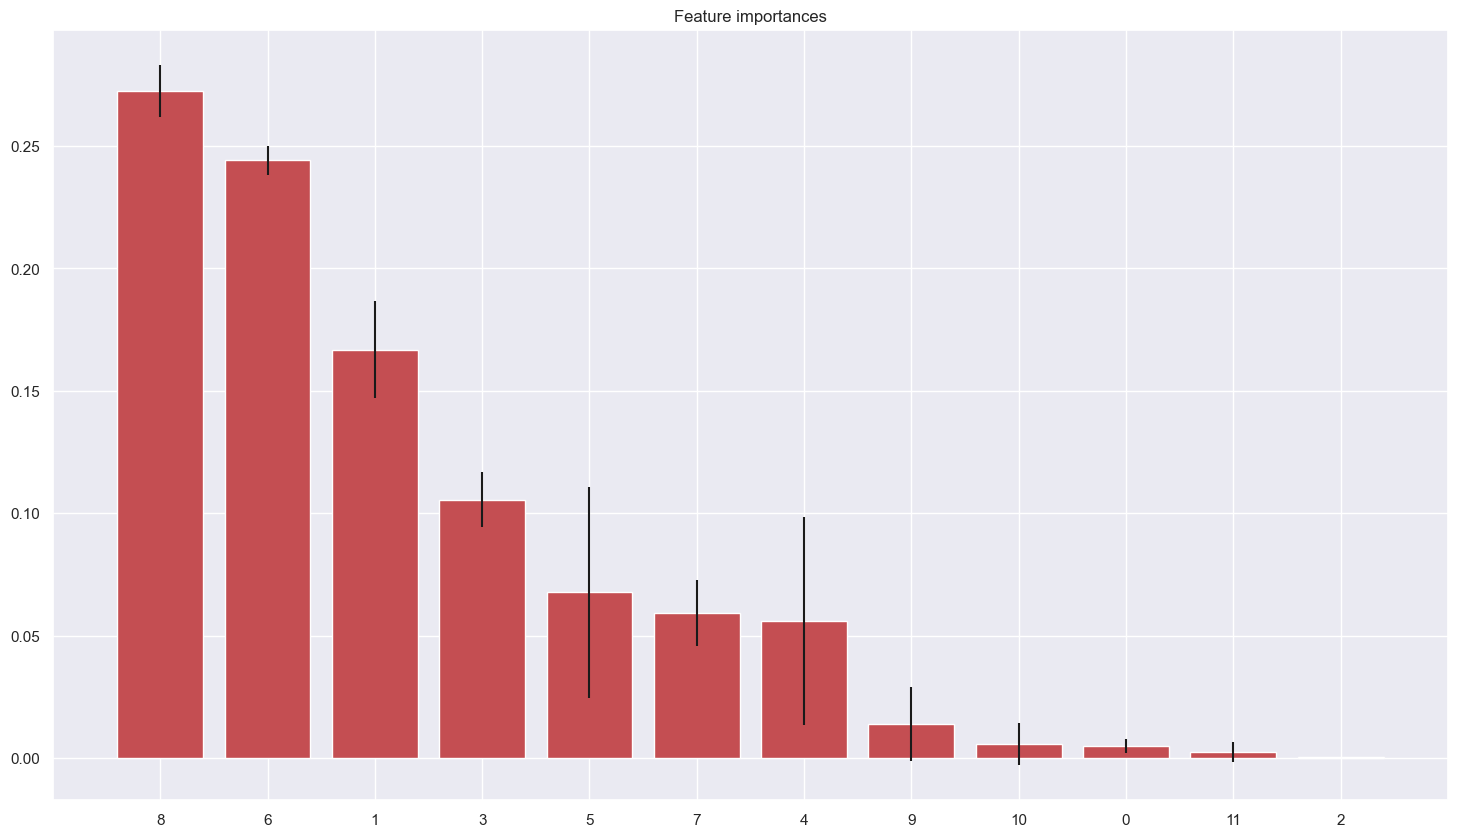

In [51]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort( importances)[::-1]

# Print the feature ranking
print( 'Feature ranking')
df = pd.DataFrame()
for i,j in zip( x_train_n, forest.feature_importances_):
    aux= pd.DataFrame( {'feature': i, 'importance':j}, index=[0])
    df = pd.concat( [df,aux], axis= 0)
    
    
print( df.sort_values('importance',ascending= False ) )

# Plot the impurity-base feature importances of the forest
plt.figure(figsize=(18,10))
plt.title( 'Feature importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color= 'r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0 Machine Learning Modelling

In [52]:
df7 = df6.copy()

In [53]:
cols_selected= ['vintage',
                'annual_premium',
                'age',
                'vehicle_damage',
                'policy_sales_channel',
                'previously_insured',
                'region_code']

In [54]:
x_train = df7[ cols_selected]
x_val = x_validation[ cols_selected]

## 7.1 KNN

In [55]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors= 5)

# model training
knn_model.fit( x_train, y_train)

# model Prediciton - Poder de Generalização
yhat_knn = knn_model.predict_proba( x_val)

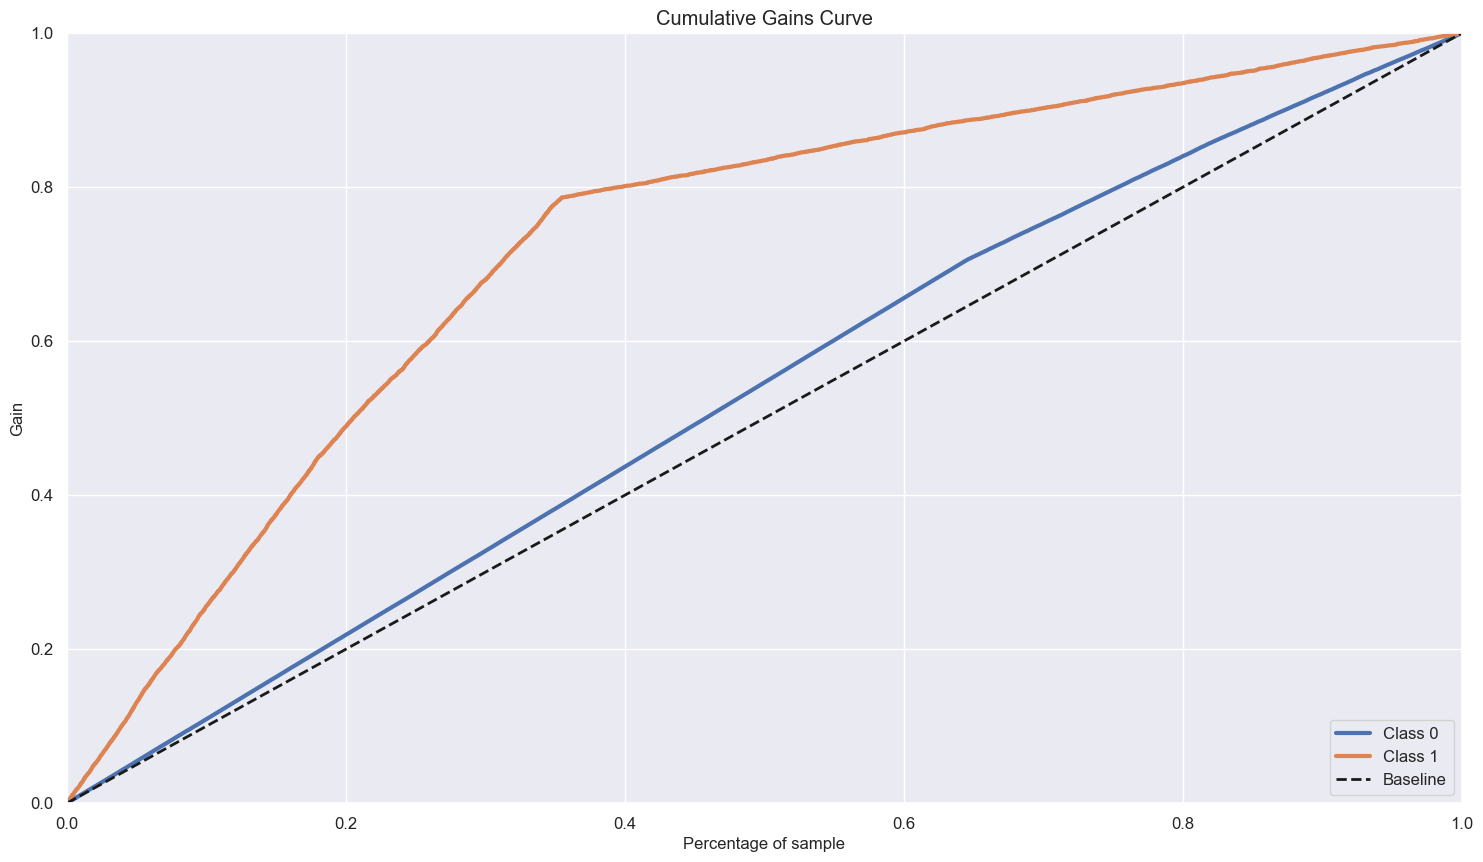

In [56]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_knn,figsize=(18,10));

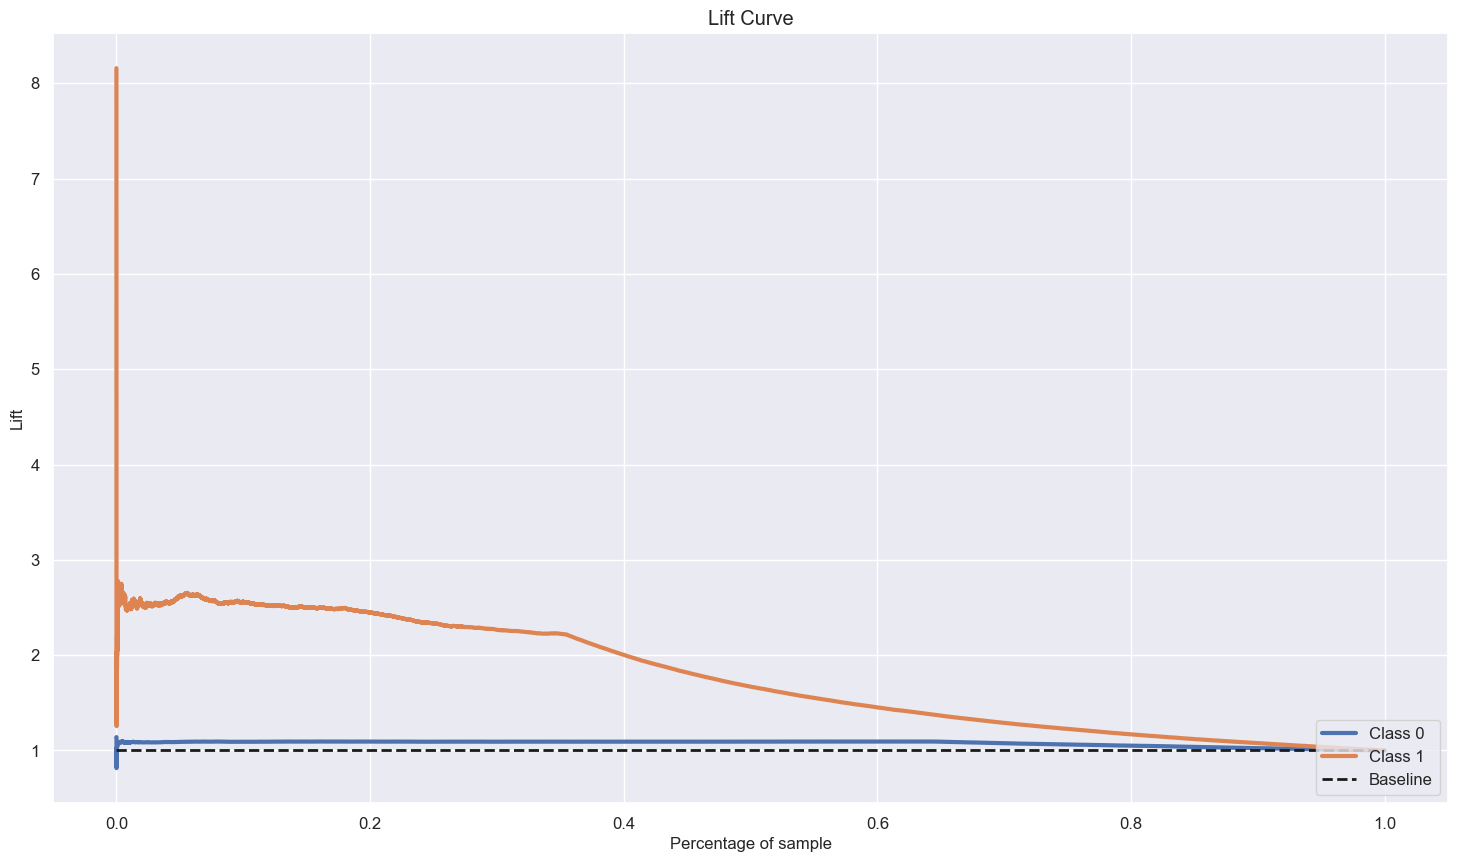

In [57]:
# Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_validation, yhat_knn,figsize=(18,10));

## 7.2 Logistic Regression

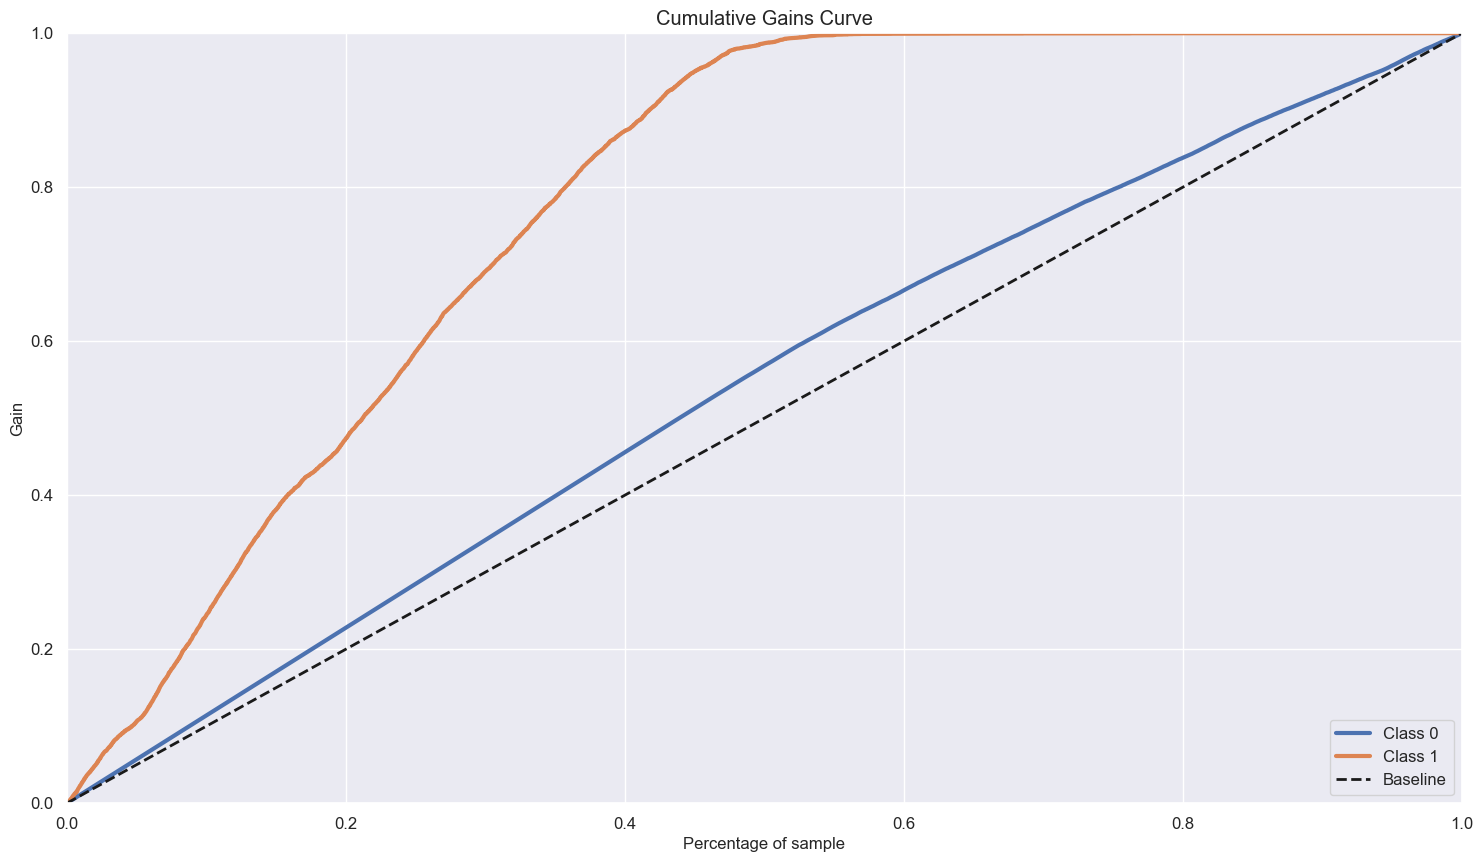

In [58]:
# model definition
lr_model = lm.LogisticRegression( random_state= 42)

# model training
lr_model.fit( x_train, y_train)

#model Prediction
yhat_lr= lr_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lr,figsize=(18,10));

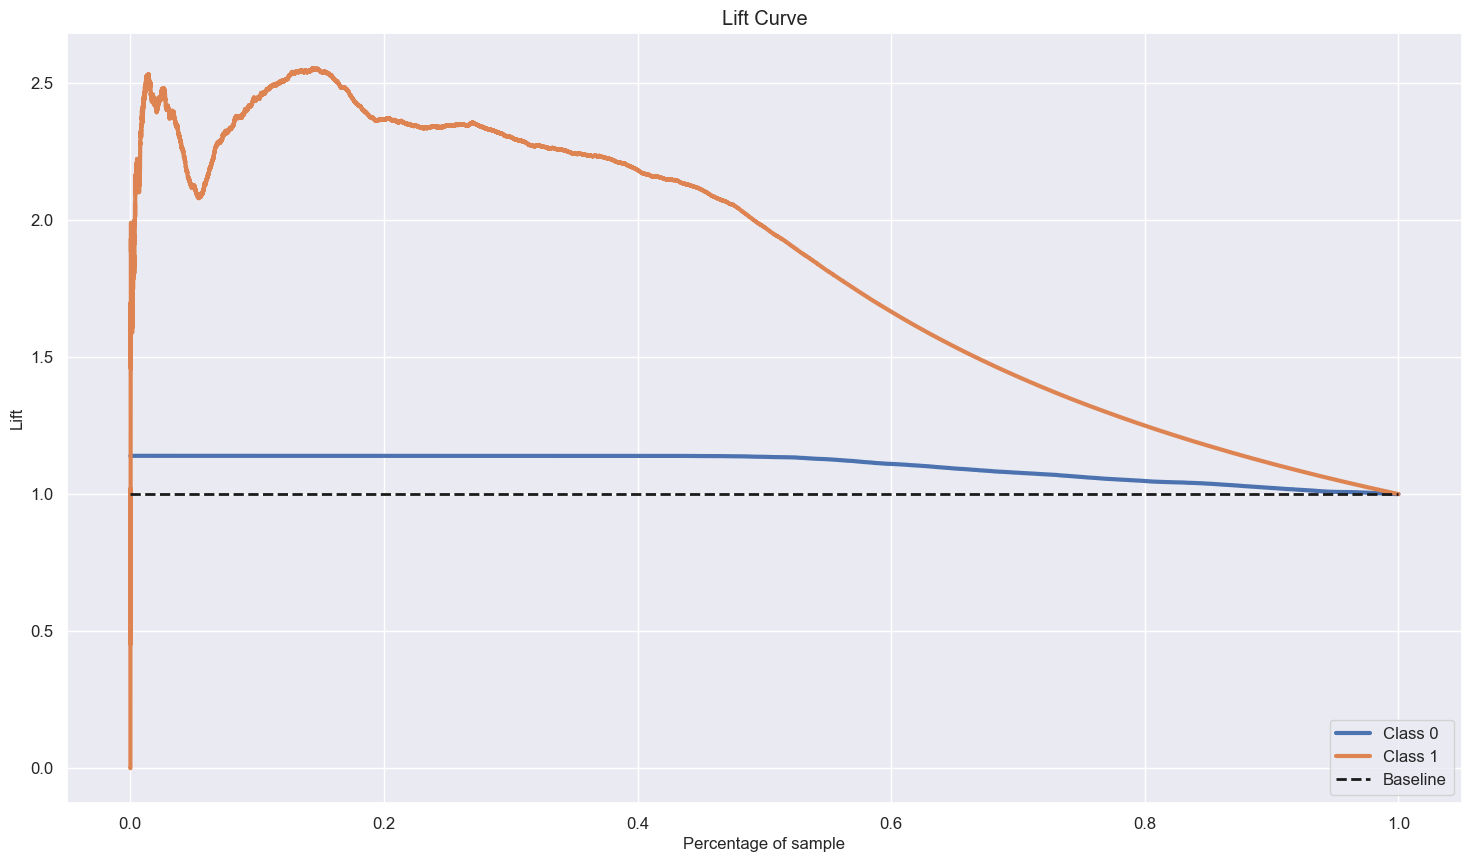

In [59]:
# Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_validation, yhat_lr,figsize=(18,10));

## 7.3 Extra Trees

In [60]:
## Model definition
et = en.ExtraTreesClassifier( n_estimators= 500, n_jobs= -1, random_state= 42 )


## Model fit
et.fit( x_train, y_train )

## Model Predict
yhat_et =  et.predict_proba( x_val )

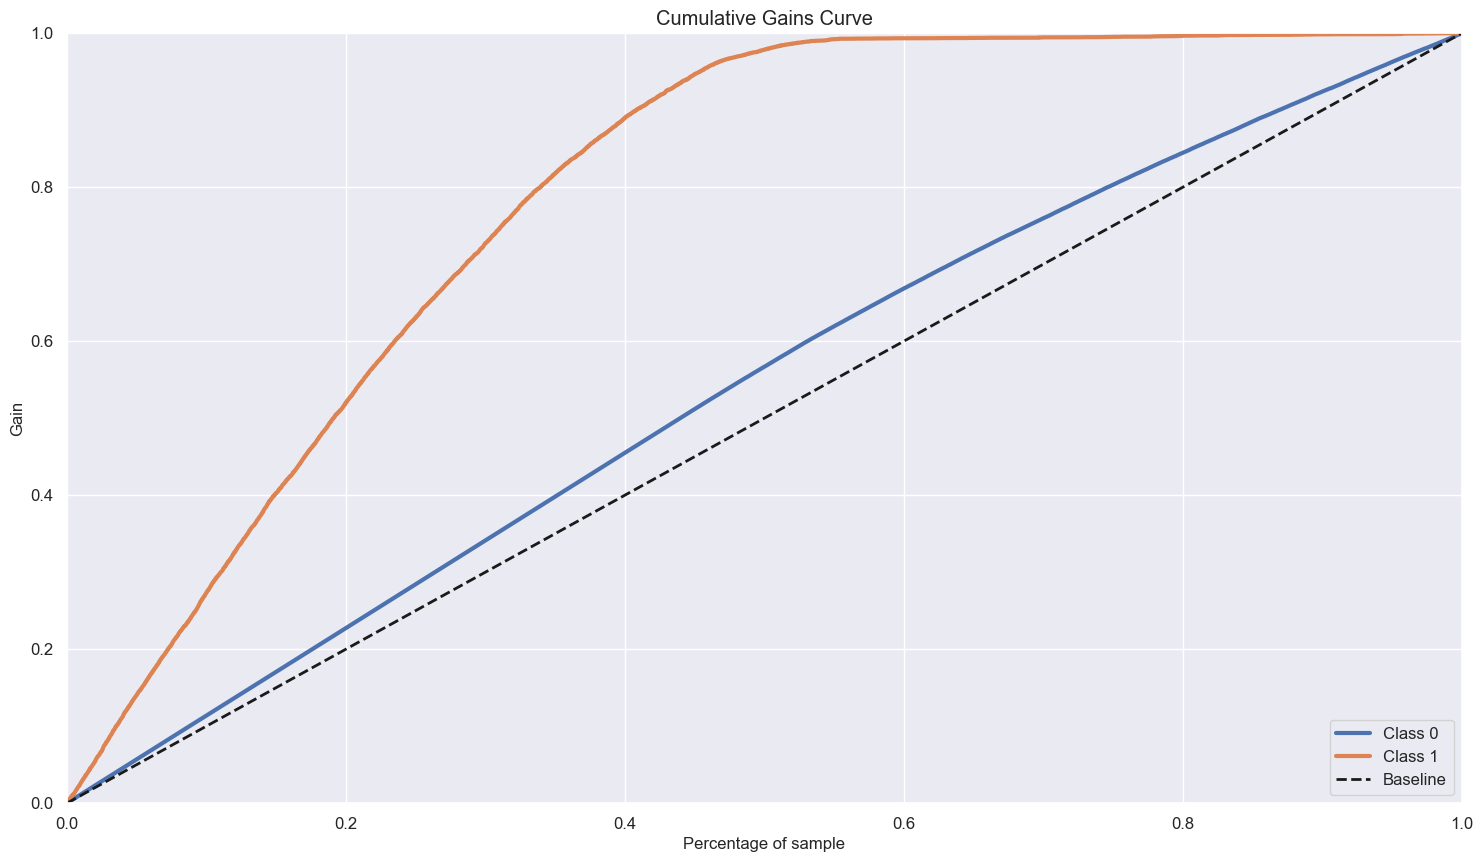

In [61]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_et,figsize=(18,10));

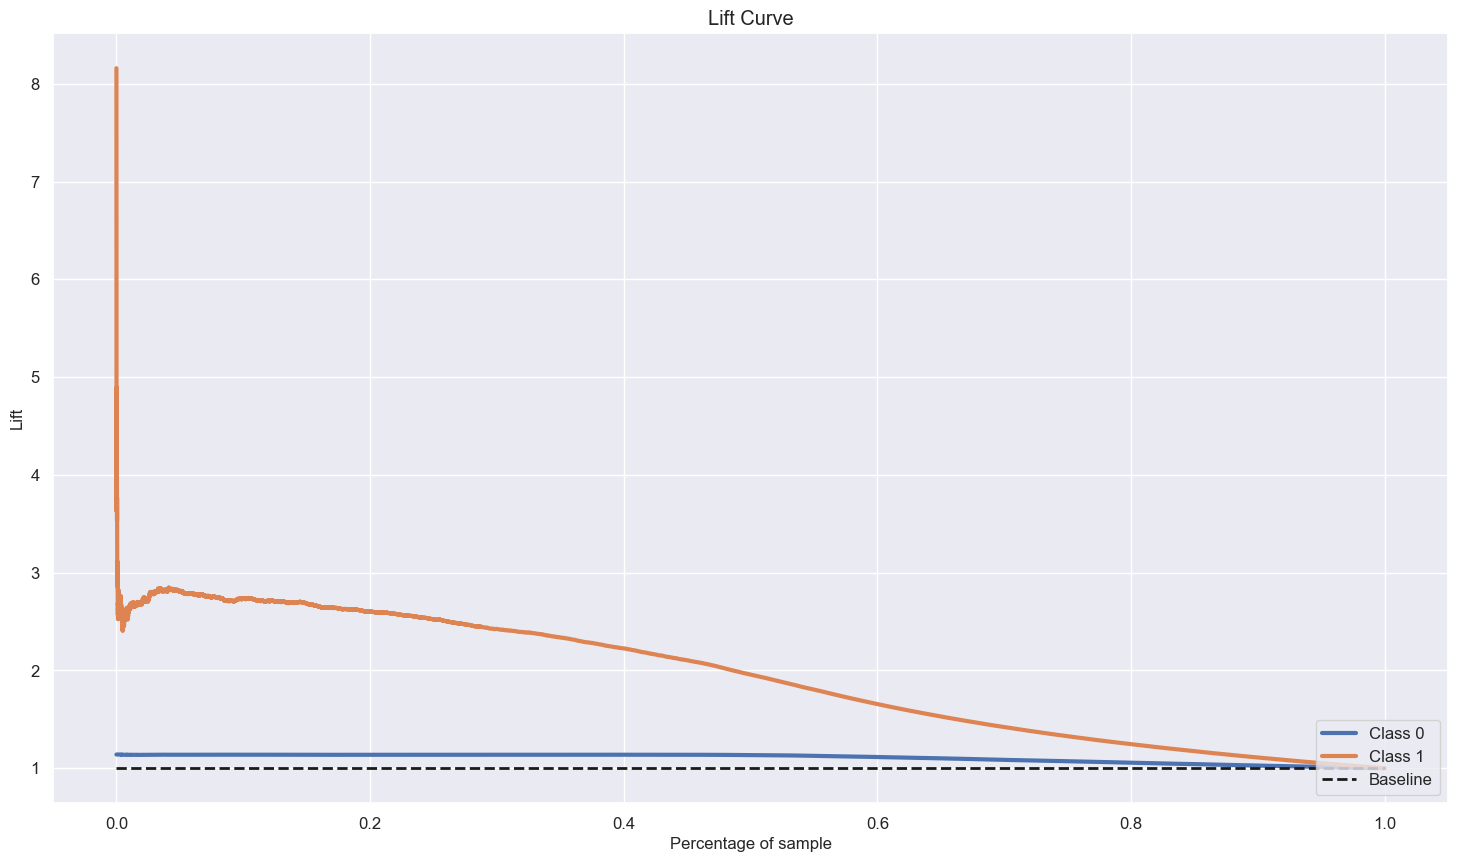

In [62]:
# Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_validation, yhat_et,figsize=(18,10));

## 7.4 Random Forest

In [63]:
## Model Definition
rf = en.RandomForestClassifier( n_estimators= 250, n_jobs= -1, random_state= 42)

## Model training
rf.fit( x_train, y_train )

## Model Prediction
yhat_rf = rf.predict_proba( x_val)

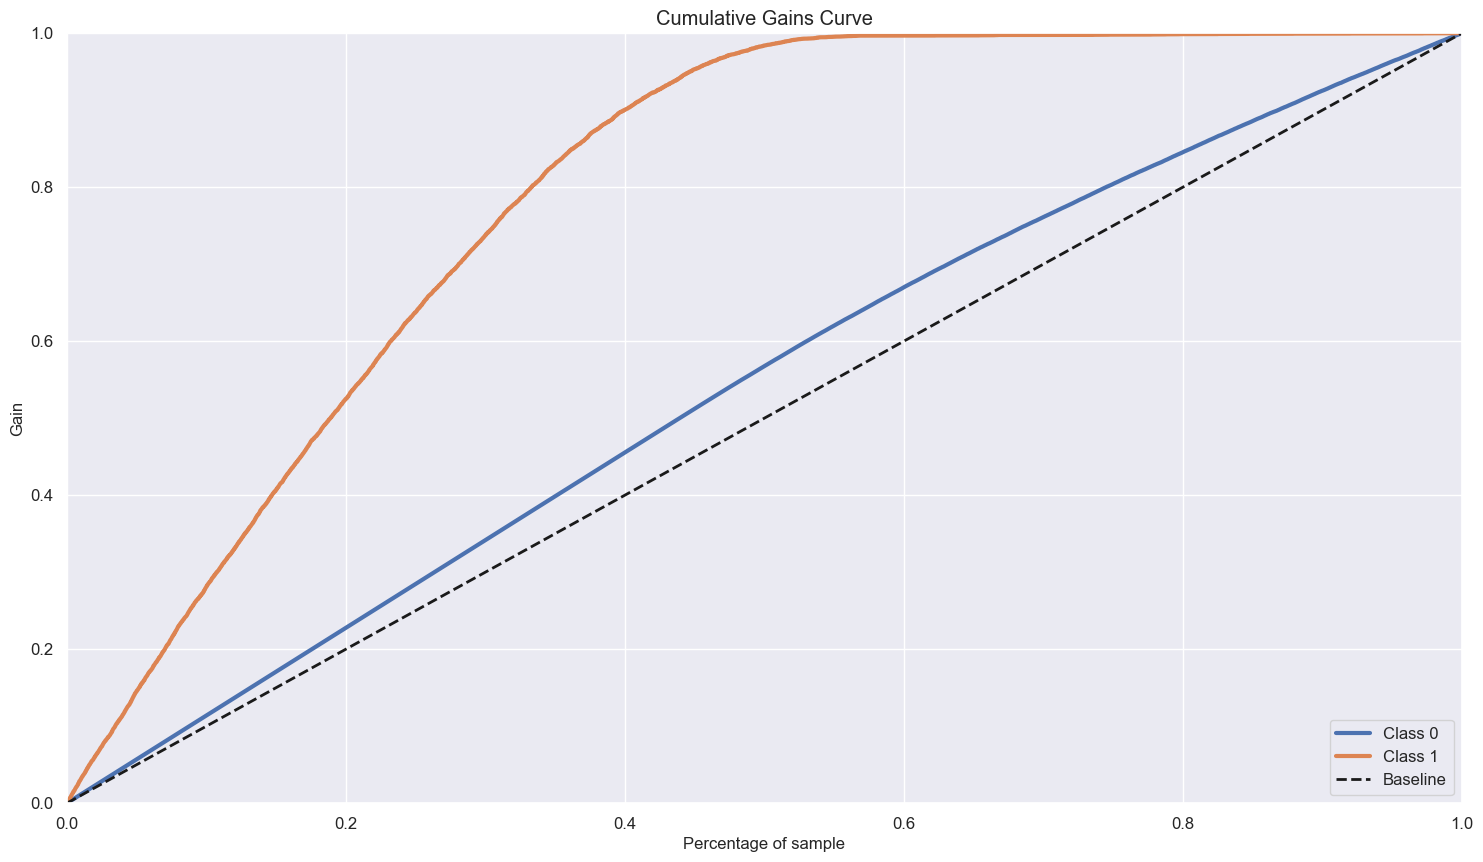

In [64]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_rf,figsize=(18,10));

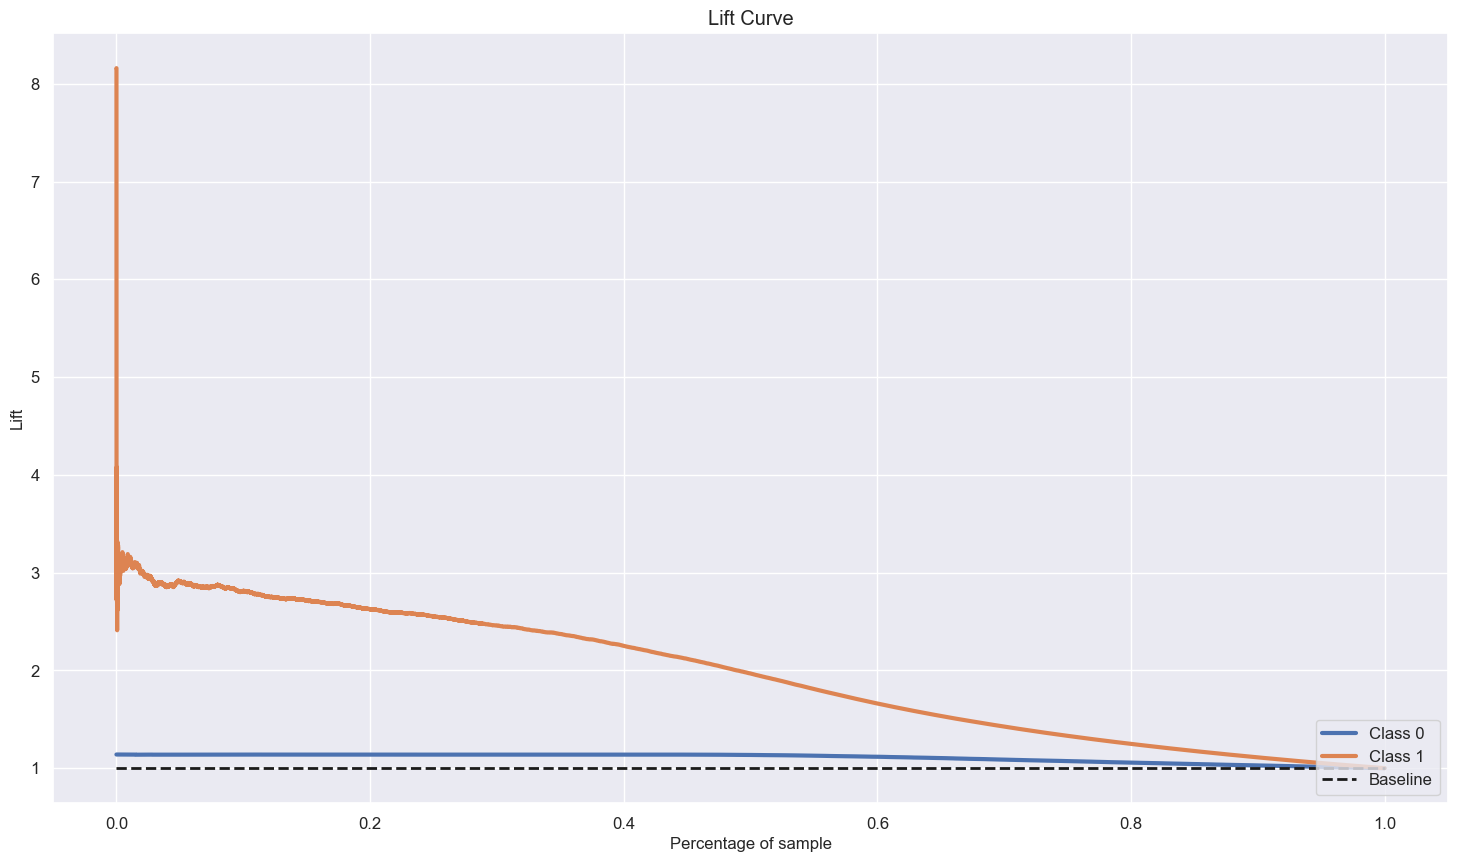

In [65]:
# Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_validation, yhat_rf,figsize=(18,10));

## 7.5 XGB

In [66]:
## Model Definition
xgb = XGBClassifier(random_state=42)

## Model training
xgb.fit( x_train, y_train )

## Model Prediction
yhat_xgb = xgb.predict_proba( x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

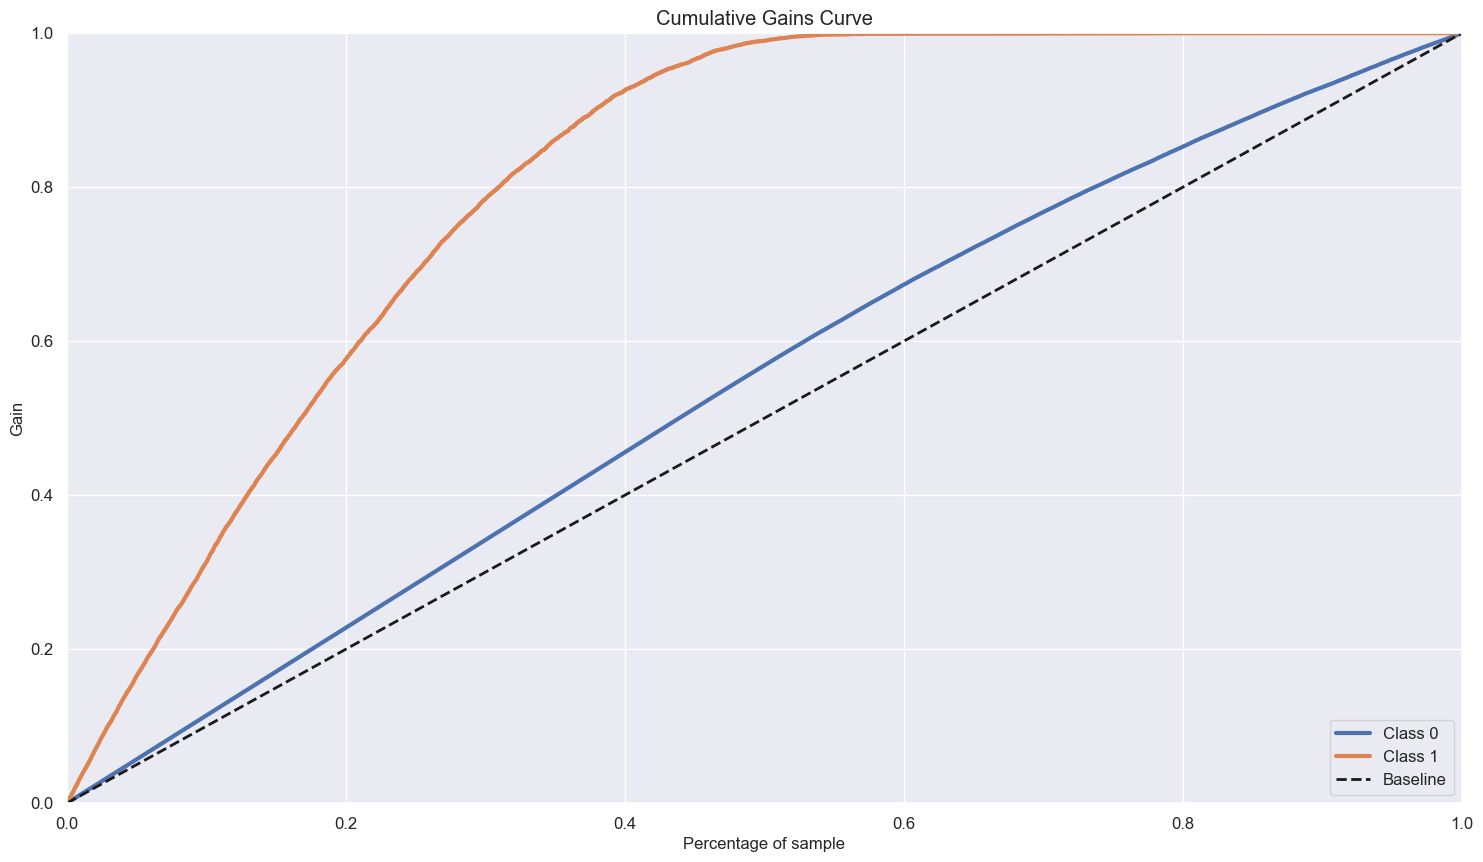

In [67]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb, figsize=(18,10))

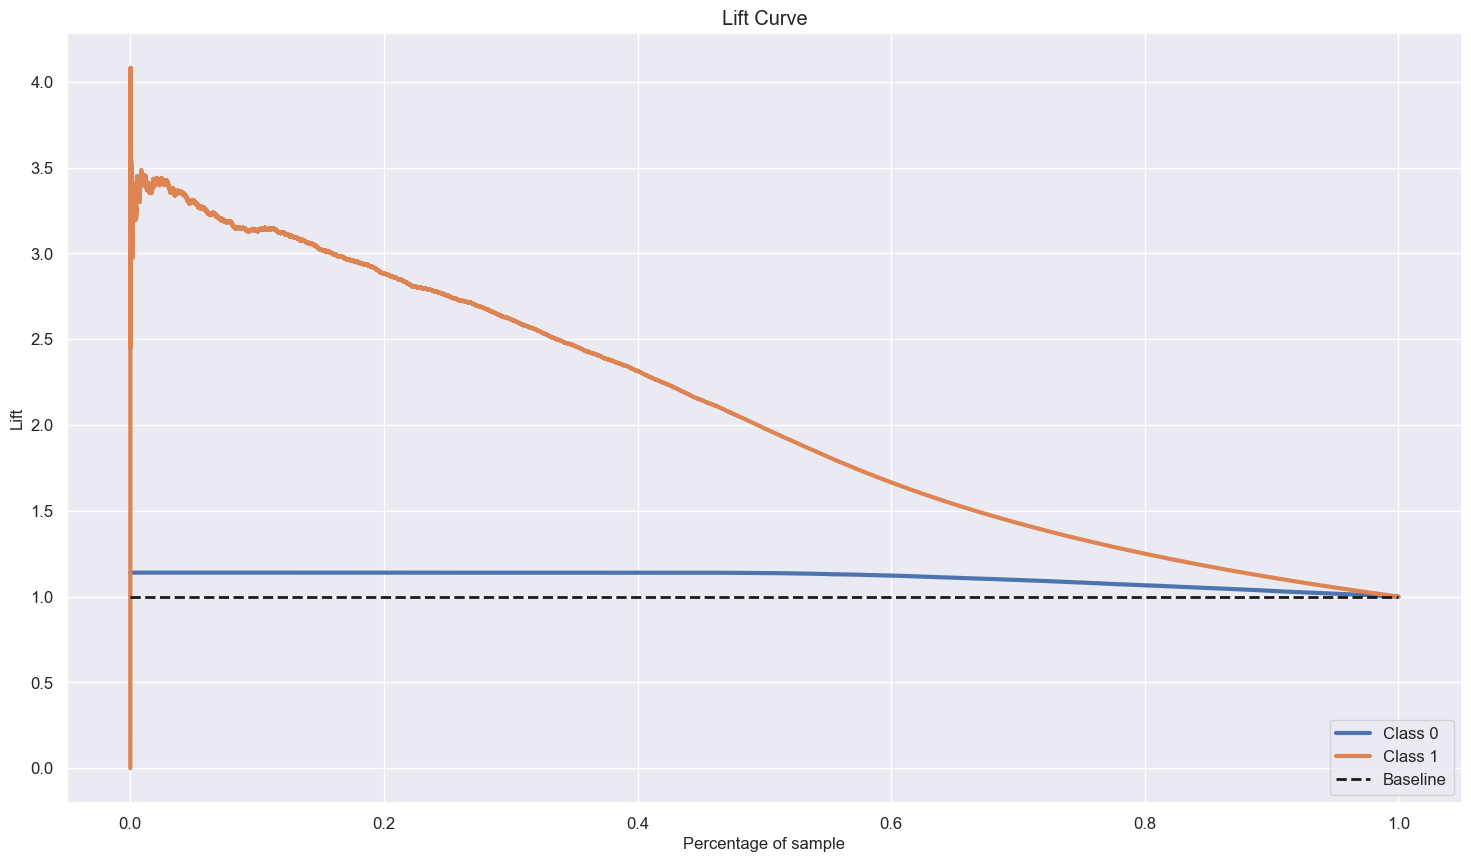

In [68]:
skplt.metrics.plot_lift_curve( y_validation, yhat_xgb,figsize=(18,10));

## 7.6 LGBM

In [69]:
## Model Definition
lgbm = LGBMClassifier(verbose=-1, random_state=42)

## Model training
lgbm.fit( x_train, y_train )

## Model Prediction
yhat_lgbm = lgbm.predict_proba( x_val)

In [70]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm, figsize=(18,10))

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

In [71]:
skplt.metrics.plot_lift_curve( y_validation, yhat_lgbm,figsize=(18,10));

## 7.7 CatBoost

In [72]:
## Model Definition
cat = CatBoostClassifier(verbose=0, random_state=42)

## Model training
cat.fit( x_train, y_train )

## Model Prediction
yhat_cat = cat.predict_proba( x_val)

In [73]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_cat, figsize=(18,10))

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

In [74]:
skplt.metrics.plot_lift_curve( y_validation, yhat_cat,figsize=(18,10));

## 7.8 Cross Validation

In [75]:
knn_model = nh.KNeighborsClassifier(n_neighbors=8, weights='distance')
lr_model  = lm.LogisticRegression(random_state = 42)
rf_model  = RandomForestClassifier(n_estimators= 250, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)
catgbm_model = CatBoostClassifier(random_state=42, logging_level='Silent')

models= [knn_model,lr_model,rf_model,dt_model, xgb_model, lgbm_model, catgbm_model]

In [94]:
cross_validation(models,x_validation,y_validation,cv=5)

Model Name  Accuracy (Avg+Std) Precision (Avg+Std)    Recall (Avg+Std)   F1-Score (Avg+Std)   ROC-AUC (Avg+Std)
0    KNeighborsClassifier  0.8563 +/- %0.0011   0.1390 +/- %0.0085  0.0332 +/- %0.0024  0.0536 +/- %0.0037  0.5019 +/- %0.0035
0      LogisticRegression  0.8774 +/- %0.0000   0.0000 +/- %0.0000  0.0000 +/- %0.0000  0.0000 +/- %0.0000  0.5029 +/- %0.0044
0  RandomForestClassifier  0.8725 +/- %0.0006   0.3808 +/- %0.0142  0.0642 +/- %0.0041  0.1099 +/- %0.0064  0.8412 +/- %0.0028
0  DecisionTreeClassifier  0.8235 +/- %0.0019   0.2914 +/- %0.0063  0.3075 +/- %0.0115  0.2992 +/- %0.0083  0.6015 +/- %0.0051
0           XGBClassifier  0.8735 +/- %0.0008   0.3973 +/- %0.0169  0.0615 +/- %0.0025  0.1066 +/- %0.0040  0.8451 +/- %0.0046
0          LGBMClassifier  0.8772 +/- %0.0005   0.4712 +/- %0.0894  0.0107 +/- %0.0029  0.0209 +/- %0.0056  0.8513 +/- %0.0040
0      CatBoostClassifier  0.8756 +/- %0.0001   0.4131 +/- %0.0107  0.0365 +/- %0.0036  0.0670 +/- %0.0062  0.8504 +/- %0.0036

## 7.8.1 Lr model fine tuning

In [95]:
# Definindo o conjunto de dados
X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)

# Definindo modelos e parâmetros
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# Definindo a busca no grid
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# resultados
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param));

Best: 0.965333 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.962667 (0.017499) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.961000 (0.014224) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.959667 (0.016630) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.962000 (0.017205) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.960667 (0.016918) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.960000 (0.016733) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.962667 (0.016519) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.960333 (0.017604) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.960667 (0.018062) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.962667 (0.018245) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.962000 (0.018690) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.961333 (0.017269) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.965000 (0.017464) wi

## 7.8.2 LGBM model fine tuning 

In [61]:
# Definindo o conjunto de dados
X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)

# Definindo modelos e parâmetros
model = LGBMClassifier()
boosting_type = ['gbdt', 'dart']
num_leaves = [10, 30, 50]
learning_rate = [0.1, 0.05, 0.01]


# Definindo a busca no grid
grid = dict(boosting_type=boosting_type, num_leaves=num_leaves, learning_rate=learning_rate)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X, y)

# resultados
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

[LightGBM] [Info] Number of positive: 500, number of negative: 500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best: 0.947667 using {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 10}
0.947667 (0.022610) with: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 10}
0.947333 (0.022201) with: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 30}
0.944667 (0.022618) with: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 50}
0.935000 (0.021409) with: {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10}
0.938333 (0.018988) with: {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 30}
0.934333 (0.022

# 8.0 Model Performance

In [76]:
# Copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# Propensity score
df8['score'] = yhat_lgbm[:,1].tolist()

# sorted clients by propensity score
df8 = df8.sort_values( 'score', ascending= False)


# Compute precison at K
precision_at_50 = precision_at_k(df8,k=50)
print(f'Precision at K: {precision_at_50}')

# Compute recall at K
recall_at_50 = recall_at_k(df8,k=50)
print(f'Recall at K: {recall_at_50}')

Precision at K: 0.3137254901960784
Recall at K: 0.0017126953543138515


In [77]:
# reset index
df8 = df8.reset_index( drop= True)

# Create Ranking order
df8['ranking'] = df8.index+1

df8['precision_at_k'] = df8['response'].cumsum()/ df8['ranking']

df8[['id', 'response', 'score','ranking','precision_at_k']].reset_index(drop= True).head()

id  response   score  ranking  precision_at_k
0  323352         0 1.00000        1         0.00000
1  333981         0 1.00000        2         0.00000
2  113570         0 1.00000        3         0.00000
3  356040         0 1.00000        4         0.00000
4  263990         0 1.00000        5         0.00000

# 9.0 Final Model

[LightGBM] [Info] Number of positive: 37368, number of negative: 267519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 304887, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122563 -> initscore=-1.968376
[LightGBM] [Info] Start training from score -1.968376


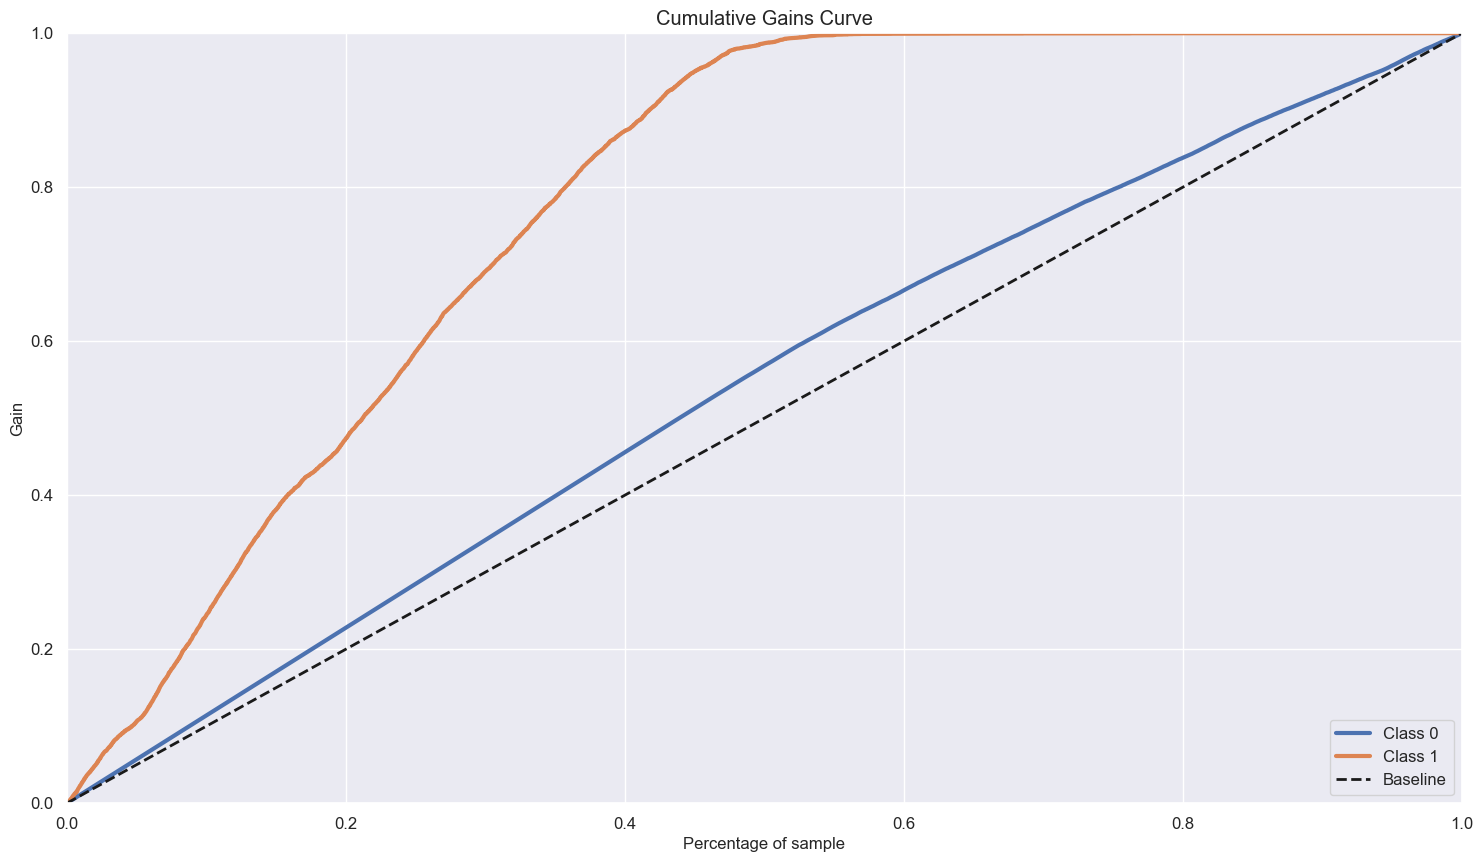

In [78]:
# model definitiion
lgbm = LGBMClassifier( boosting_type= 'gbdt', learning_rate= 0.1, num_leaves= 10)

# model training
lgbm.fit( x_train, y_train)

#model Prediction
yhat_lgbm= lgbm.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lr,figsize=(18,10));

# 10.0 Business Performance

In [79]:
# custo da ligação e base dos 80 % dos clientes
bus= {'lig':[0.18,0.18],'clients': [381109,141010]}
df10=pd.DataFrame(data=bus)
df10['custo']= df10['lig']*df10['clients']
df10

lig  clients       custo
0 0.18000   381109 68599.62000
1 0.18000   141010 25381.80000

- Com o resultado mostrado acima, conseguimos alcançar mais de 80% dos clientes na base, com um lucro percentual de aproximadamente 62%.